---
# Mathematics of Machine and Deep Learning Algorithms 
### COVID 19 NLP Text Classification and Generation 
### M2 MED & D3S 
#### TSE
#### 2021-2022
---
Authors : Emir Tarık DAKIN & Nhat Thang LE  

## 1. Dataset

Coronavirus Tweets: available at [kaggle.com/datatattle/covid-19-nlp-text-classification](https://kaggle.com/datatattle/covid-19-nlp-text-classification).

This dataset contains tweets from 2020, related to Coronavirus, with date and location. Each tweet was manually labelled regarding the sentiment expressed, hence this dataset is fitted for sentiment analysis but also
for classification and topic identification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from matplotlib.pyplot import figure

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import re
import string
import unicodedata

# Others
import time
from pprint import pprint
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2. Document content exploration

### 2.1 **Download** the dataset (train and test)

#### 2.1.1 Download directly from Kaggle (faster)

This process requires Kaggle API credentials.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [4]:
# download an unzip data
!kaggle datasets download datatattle/covid-19-nlp-text-classification
!unzip covid-19-nlp-text-classification.zip

  0% 0.00/4.38M [00:00<?, ?B/s]
100% 4.38M/4.38M [00:00<00:00, 72.0MB/s]
Archive:  covid-19-nlp-text-classification.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


#### 2.1.2 Alternatively, upload manually (slower)

In [ ]:
from google.colab import files
files.upload()

#### 2.1.3 Loading the data and doing some basic changes

In [5]:
train_raw = pd.read_csv("Corona_NLP_train.csv", encoding = 'latin1')
test_raw = pd.read_csv("Corona_NLP_test.csv", encoding = 'latin1')
train =  train_raw.copy()
test  =  test_raw.copy()

In [6]:
train.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [7]:
# train and test merge
df_raw = pd.concat([train,test])
df_raw.reset_index(drop=True).copy()
df = df_raw.reset_index(drop=True).copy()

# tweets and sentiments as strings
df['OriginalTweet'] = df['OriginalTweet'].astype(str)
df['Sentiment'] = df['Sentiment'].astype(str)

train['OriginalTweet'] = train['OriginalTweet'].astype(str)
train['Sentiment'] = train['Sentiment'].astype(str)

test['OriginalTweet'] = test['OriginalTweet'].astype(str)
test['Sentiment'] = test['Sentiment'].astype(str)
df.tail(10)

UserName  ...           Sentiment
44945      3789  ...             Neutral
44946      3790  ...  Extremely Positive
44947      3791  ...            Positive
44948      3792  ...  Extremely Negative
44949      3793  ...            Negative
44950      3794  ...            Positive
44951      3795  ...            Negative
44952      3796  ...             Neutral
44953      3797  ...  Extremely Negative
44954      3798  ...  Extremely Positive

[10 rows x 6 columns]

In [8]:
df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [9]:
# tweet dates to date time format
df['TweetAt'] = pd.to_datetime(df['TweetAt'].values, format='%d-%m-%Y')
train['TweetAt'] = pd.to_datetime(train['TweetAt'].values, format='%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'].values, format='%d-%m-%Y')

df.dtypes

UserName                  int64
ScreenName                int64
Location                 object
TweetAt          datetime64[ns]
OriginalTweet            object
Sentiment                object
dtype: object

In [10]:
# checking dates
print(df['TweetAt'].max())
print(train['TweetAt'].max())
print(test['TweetAt'].max())

2020-04-14 00:00:00
2020-04-14 00:00:00
2020-03-16 00:00:00


### 2.2 **Represent** the "sentiment" distribution over the dataset, and its evolution with time

In [11]:
df.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [12]:
# number of tweets by sentiment
class_df = df.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
class_df.style.background_gradient(cmap='magma')

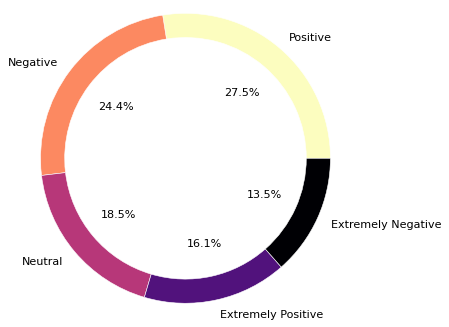

In [13]:
# percentage of tweets by sentiment
percent_class = class_df.OriginalTweet
labels = class_df.Sentiment

colors = ['#fcfdbf','#fc8961','#b73779','#51127c','#000004'] # positive-negative-neutral-exp-exn

figure(figsize=(5, 5), dpi=80)

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.2, edgecolor='white') 
plt.show()

([], <a list of 0 Text major ticklabel objects>)

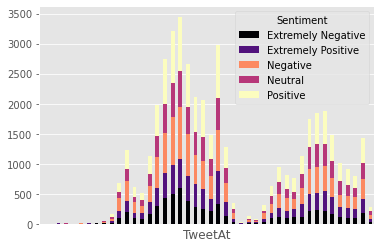

In [14]:
colors2 = ['#000004','#51127c','#fc8961','#b73779','#fcfdbf'] # positive-negative-neutral-exp-exn

# sentiment over time - bar plot
pd.crosstab(df.TweetAt,df.Sentiment).plot.bar(stacked=True, color=colors2)
plt.xticks([]) # disable date ticks

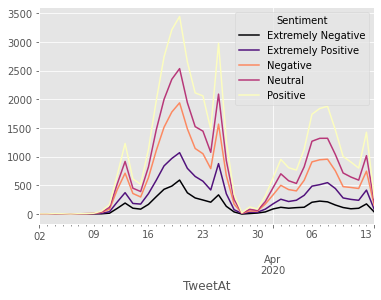

In [15]:
# sentiment over time - time series plot
pd.crosstab(df.TweetAt,df.Sentiment).plot(stacked=True, color=colors2)

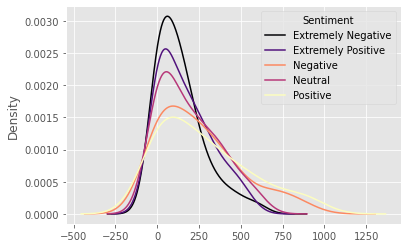

In [16]:
# sentiment over time - density plot
pd.crosstab(df.TweetAt,df.Sentiment).plot.density(stacked=True, color=colors2)

### 2.3 **Produce** some quantitative elements that describe the dataset.

In [17]:
df['month'] = df['TweetAt'].dt.month # split month from tweet date
df['year'] = df['TweetAt'].dt.year # split year from tweet date
df['month_year'] = pd.to_datetime(df[['month', 'year']].assign(DAY=1)) # combine month and year to use for groupby

In [18]:
# simple monthly sentiment counts
df.groupby(['month_year','Sentiment']).size()

month_year  Sentiment         
2020-03-01  Extremely Negative    4196
            Extremely Positive    4593
            Negative              7342
            Neutral               5205
            Positive              7961
2020-04-01  Extremely Negative    1877
            Extremely Positive    2630
            Negative              3616
            Neutral               3127
            Positive              4408
dtype: int64

In [19]:
df['length'] = df['OriginalTweet'].str.len() # number of characters in each tweet
df.groupby('Sentiment').agg({'length': 'mean'}) # 

## Comment: extreme tweets tend to be longer (positive or negative). Neutral tweets are the shortest (on average)

length
Sentiment                     
Extremely Negative  222.766014
Extremely Positive  229.274124
Negative            204.282716
Neutral             168.160826
Positive            207.616299

In [20]:
df['Location'].value_counts()[:19] #  This shows most tweeted 20 locations, not yet cleaned

United States              603
London, England            568
London                     565
New York, NY               429
Washington, DC             411
United Kingdom             355
Los Angeles, CA            314
India                      283
UK                         246
USA                        243
Australia                  236
Canada                     220
England, United Kingdom    201
Toronto, Ontario           189
California, USA            179
San Francisco, CA          171
Chicago, IL                170
Global                     164
Boston, MA                 156
Name: Location, dtype: int64

In [21]:
# cleaning locations by combining duplicates and counting tweets
df['Location_Clean'] = df['Location'].str.split(",").str[0]
top20_locations = df['Location_Clean'].value_counts()[:19]
top20_locations

### Comment: Most tweets come from London (UK) and big cities from US. This makes sense because almost every tweet is in English

London            1335
New York           767
United States      605
Washington         556
Los Angeles        455
Toronto            411
United Kingdom     361
India              293
Chicago            284
England            271
UK                 260
USA                252
Australia          241
California         238
San Francisco      230
Canada             228
Melbourne          218
Sydney             213
Boston             211
Name: Location_Clean, dtype: int64

Text(0.5, 1.0, 'Tweet locations')

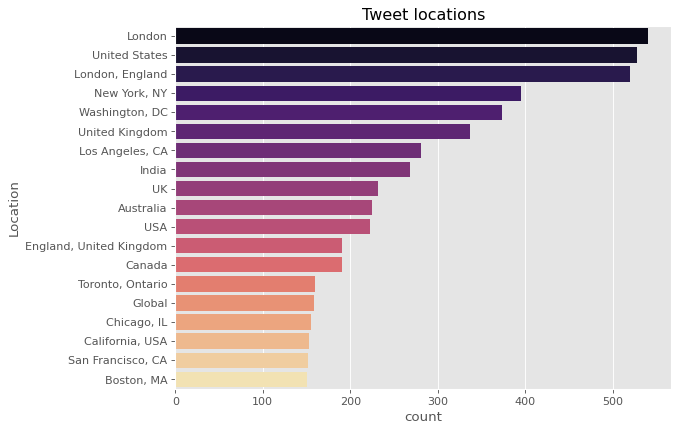

In [22]:
# tweet locations - bar plot
plt.figure(figsize=(8,6), dpi=80)
sns.countplot(y='Location',data=train,order=train.Location.value_counts().iloc[
    0:19].index, palette='magma').set_title("Tweet locations")
    
## Comment: A better visualization of the locations

### 2.4 **Clean** the dataset with `nltk`

#### Removing urls

In [23]:
## Define a function that removes all the urls in the tweets
def remove_urls(text):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", text).split())

In [24]:
no_urls       = [remove_urls(tweet) for tweet in    df['OriginalTweet'] ]  ### Remove urls better, note that it also removes punctuations
no_urls_train = [remove_urls(tweet) for tweet in train['OriginalTweet'] ] 
no_urls_test  = [remove_urls(tweet) for tweet in  test['OriginalTweet'] ] 

In [25]:
## Let's check a few tweets
no_urls[111:115]

['A supermarket in La Habra is trying to help local seniors during the COVID19 pandemic by opening its doors a halfhour early each day exclusively for shoppers 65 and older',
 'They should have something where the elderly and the people who dont stock up a ton of food essentials can buy what they need first then the more greedy and panick buyers can get what they need stoppanickbuying thinkingofothers coronavirus COVID19',
 'Kids Get Mild COVID19 Symptoms But Chance of Transmission High Study',
 'New CSPI consumers guide examines how 20 largest restaurant chains by sales are handling paid sick leave during COVID19 pandemic Results not good 60 didnt disclose any paid leave policy and only 3 chains offer sick leave at all locations nationwide']

In [26]:
## Replace the datasets with no urls in tweets

df['OriginalTweet']     = no_urls.copy()
train['OriginalTweet']  = no_urls_train.copy()
test['OriginalTweet']   = no_urls_test.copy()


#### Lowercase text, remove urls and punctuation

In [27]:
### Define some functions to lowercase the words and remove some punctuations

def convert_text_to_lowercase(data, colname):
    df = data.copy()
    df[colname] = df[colname].str.lower()
    return df

def not_regex(pattern):
        return r"((?!{}).)".format(pattern)
        
def remove_punctuation(data, colname):
    df = data.copy()
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df
def lower_punctuation(data, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    """
    df = data.copy()
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
    )
    return df

In [28]:
### Clean the datasets with lowercasing and removing punctuations, nearly half way from cleaning

train_halfway = lower_punctuation(train, 'OriginalTweet')
test_halfway  = lower_punctuation(test,  'OriginalTweet')
df_halfway    = lower_punctuation(df,    'OriginalTweet')

In [29]:
## Let's take a look
train_halfway['OriginalTweet'][109] # seems to do the job

'update make sure to check your local listings to see what is openclosed at what timeschickfila drive through onlystarbucks using togo modelearly closing include king soopers sams club etc'

#### Tokenizing the tweets

In [30]:
### We begin tokenizing the sentences using nltk:
## First, extract vectors of "OriginalTweet" from each datasets (train, test and df)

tokens_train_halfway = [word_tokenize(tweet) for tweet in train_halfway['OriginalTweet'] ]
tokens_test_halfway  = [word_tokenize(tweet) for tweet in  test_halfway['OriginalTweet'] ]
tokens_df_halfway    = [word_tokenize(tweet) for tweet in    df_halfway['OriginalTweet'] ]

## Replace the columns OriginalTweet with these tokenized vectors
train_halfway_tokenized = train_halfway.copy()
test_halfway_tokenized  = test_halfway.copy()
df_halfway_tokenized    = df_halfway.copy()

train_halfway_tokenized['OriginalTweet']  = tokens_train_halfway.copy()
test_halfway_tokenized['OriginalTweet']   = tokens_test_halfway.copy()
df_halfway_tokenized['OriginalTweet']     = tokens_df_halfway.copy()

#### Removing stopwords

In [31]:
### Define a function to remove stop words that return the whole dataset

def remove_stop_words(data, colname):
    df = data.copy()
    stop_words = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df


### Finally we have the cleaned data with no STEMMING

train_cleaned = remove_stop_words( train_halfway_tokenized , 'OriginalTweet')
test_cleaned = remove_stop_words( test_halfway_tokenized , 'OriginalTweet')
df_cleaned = remove_stop_words( df_halfway_tokenized , 'OriginalTweet')

In [32]:
# cleaned and tokenized no stem tweets
df_cleaned['OriginalTweet'].tail(10)

44945    [never, eaten, pigs, cat, dog, food, internati...
44946    [calebmealer, thebradfordfile, realdonaldtrump...
44947    [even, though, law, library, closed, subscribe...
44948    [gov, hogans, announcement, bars, restaurants,...
44949    [ricepolitics, mdcounties, craig, call, genera...
44950    [meanwhile, supermarket, israel, people, dance...
44951    [panic, buy, lot, nonperishable, items, echo, ...
44952    [asst, prof, economics, cconces, nbcphiladelph...
44953    [gov, need, somethings, instead, biar, je, rak...
44954    [forestandpaper, members, committed, safety, e...
Name: OriginalTweet, dtype: object

#### Additional: Stemming on the cleaned datasets

In [33]:
## We begin to do some "Stemming" on words

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

stemmed_train = []
stemmed_test  = []
stemmed_df    = []

for tweet in train_cleaned['OriginalTweet']:
  a = [porter.stem(word) for word in tweet]
  stemmed_train.append(a)

for tweet in test_cleaned['OriginalTweet']:
  b = [porter.stem(word) for word in tweet]
  stemmed_test.append(b)

for tweet in df_cleaned['OriginalTweet']:
  c = [porter.stem(word) for word in tweet]
  stemmed_df.append(c)

In [34]:
train_cleaned_stemmed = train_cleaned.copy()
test_cleaned_stemmed  = test_cleaned.copy()
df_cleaned_stemmed    = df_cleaned.copy()

train_cleaned_stemmed['OriginalTweet'] = stemmed_train
test_cleaned_stemmed['OriginalTweet']  = stemmed_test
df_cleaned_stemmed['OriginalTweet']    = stemmed_df

In [35]:
# cleaned, tokenized and stemmed tweets
df_cleaned_stemmed['OriginalTweet'][12]

['horningsea',
 'care',
 'commun',
 'let',
 'look',
 'less',
 'capabl',
 'villag',
 'ensur',
 'stay',
 'healthi',
 'bring',
 'shop',
 'door',
 'help',
 'onlin',
 'shop',
 'self',
 'isol',
 'symptom',
 'expos',
 'somebodi']

#### Additional: Lemmatization on the cleaned datasets (will be used later to compare and to see if Lemmatization help)

In [36]:
## We begin to do some "Lemmatization" to the words

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

lemma_train = []
lemma_test  = []
lemma_df    = []

for tweet in train_cleaned['OriginalTweet']:
  a = [lemmatizer.lemmatize(word) for word in tweet]
  lemma_train.append(a)

for tweet in test_cleaned['OriginalTweet']:
  b = [lemmatizer.lemmatize(word) for word in tweet]
  lemma_test.append(b)

for tweet in df_cleaned['OriginalTweet']:
  c = [lemmatizer.lemmatize(word) for word in tweet]
  lemma_df.append(c)

In [37]:
train_cleaned_lemmatized = train_cleaned.copy()
test_cleaned_lemmatized  = test_cleaned.copy()
df_cleaned_lemmatized    = df_cleaned.copy()

train_cleaned_lemmatized['OriginalTweet'] = lemma_train
test_cleaned_lemmatized['OriginalTweet']  = lemma_test
df_cleaned_lemmatized['OriginalTweet']    = lemma_df

In [38]:
### Let's check a few words. Note that 'less' has been turned into 'le' by WordNetLemmatizer(), this is quite a problem because 'less' can somehow mean
### negative in some contexts.

df_cleaned_lemmatized['OriginalTweet'][12]

## Comment: most words are changed, the most striking thing is the word "less" is changed to "le", which has no meaning
## We predict lemmatization will not help in following tests.

['horningsea',
 'caring',
 'community',
 'let',
 'look',
 'le',
 'capable',
 'village',
 'ensure',
 'stay',
 'healthy',
 'bringing',
 'shopping',
 'door',
 'help',
 'online',
 'shopping',
 'self',
 'isolation',
 'symptom',
 'exposed',
 'somebody']

### 2.5 **Produce** a cloud of words

In [39]:
df_cleaned_cloud = df_cleaned.copy()
df_cleaned_cloud['OriginalTweet'] = pd.Series(df_cleaned['OriginalTweet'], dtype="string") # cleaned and tokenized words as string
df_cleaned_cloud['OriginalTweet'] # now they are string tokens that are convenient for the word cloud

0                    ['menyrbie', 'philgahan', 'chrisitv']
1        ['advice', 'talk', 'neighbours', 'family', 'ex...
2        ['coronavirus', 'australia', 'woolworths', 'gi...
3        ['food', 'stock', 'one', 'emptyplease', 'dont'...
4        ['ready', 'go', 'supermarket', 'covid19', 'out...
                               ...                        
44950    ['meanwhile', 'supermarket', 'israel', 'people...
44951    ['panic', 'buy', 'lot', 'nonperishable', 'item...
44952    ['asst', 'prof', 'economics', 'cconces', 'nbcp...
44953    ['gov', 'need', 'somethings', 'instead', 'biar...
44954    ['forestandpaper', 'members', 'committed', 'sa...
Name: OriginalTweet, Length: 44955, dtype: string

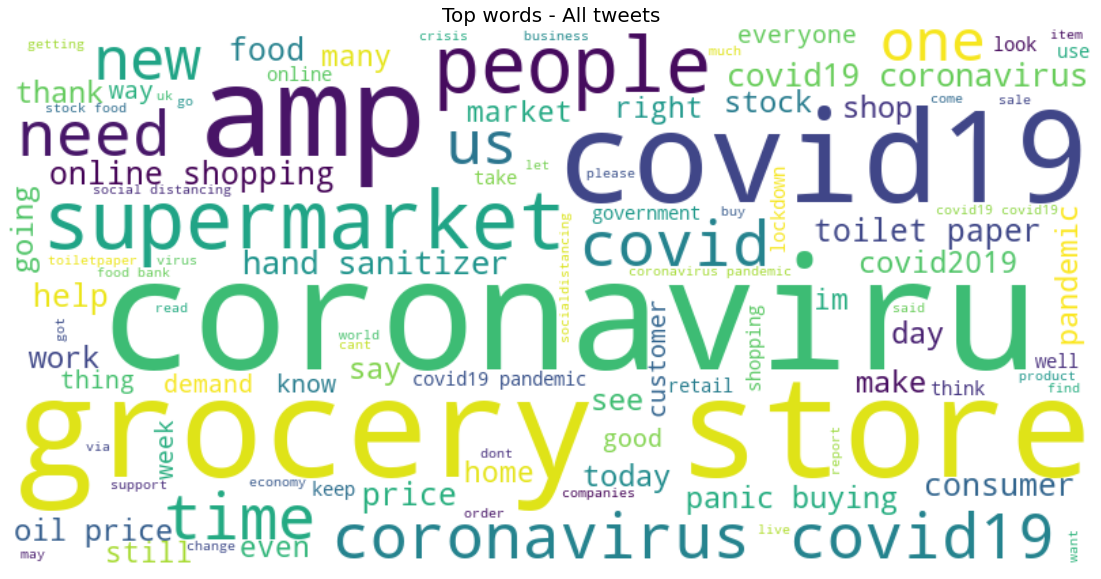

In [40]:
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      max_words=100)

wordcloud.generate(' '.join(text for text in df_cleaned_cloud['OriginalTweet'].str.replace("'", ""))) # removing apostrophes since the tokens are now strings

plt.figure(figsize=(20,10))
plt.title("Top words - All tweets", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show() # word cloud for the whole dataset

### 2.6 **Show** the most frequent words used in tweets according to the sentiment expressed

In [41]:
import itertools
import collections

In [42]:
### Creating sub-datasets according to the sentiments from the cleaned dataset without stemming or lemmatizing.

expos_nostem = df_cleaned[(df_cleaned['Sentiment'] == 'Extremely Positive')]
pos_nostem   = df_cleaned[(df_cleaned['Sentiment'] == 'Positive')]
neu_nostem   = df_cleaned[(df_cleaned['Sentiment'] == 'Neutral')]
neg_nostem   = df_cleaned[(df_cleaned['Sentiment'] == 'Negative')]
exneg_nostem = df_cleaned[(df_cleaned['Sentiment'] == 'Extremely Negative')]

### Creating sub-datasets according to the sentiments from the cleaned + stemmed dataset.

expos_stemmed = df_cleaned_stemmed[(df_cleaned_stemmed['Sentiment'] == 'Extremely Positive')]
pos_stemmed   = df_cleaned_stemmed[(df_cleaned_stemmed['Sentiment'] == 'Positive')]
neu_stemmed   = df_cleaned_stemmed[(df_cleaned_stemmed['Sentiment'] == 'Neutral')]
neg_stemmed   = df_cleaned_stemmed[(df_cleaned_stemmed['Sentiment'] == 'Negative')]
exneg_stemmed = df_cleaned_stemmed[(df_cleaned_stemmed['Sentiment'] == 'Extremely Negative')]

### Creating sub-datasets according to the sentiments from the cleaned + lemmatized dataset.

expos_lemmatized = df_cleaned_lemmatized[(df_cleaned_lemmatized['Sentiment'] == 'Extremely Positive')]
pos_lemmatized   = df_cleaned_lemmatized[(df_cleaned_lemmatized['Sentiment'] == 'Positive')]
neu_lemmatized   = df_cleaned_lemmatized[(df_cleaned_lemmatized['Sentiment'] == 'Neutral')]
neg_lemmatized   = df_cleaned_lemmatized[(df_cleaned_lemmatized['Sentiment'] == 'Negative')]
exneg_lemmatized = df_cleaned_lemmatized[(df_cleaned_lemmatized['Sentiment'] == 'Extremely Negative')]

#####

### Extract all words in each datasets, cleaned with no stemming or lemmatizing, cleaned +stemmed,  and cleaned+lemmatized
all_words_df_nostem = list(itertools.chain(*df_cleaned['OriginalTweet']))
all_words_df_stemmed = list(itertools.chain(*df_cleaned_stemmed['OriginalTweet']))
all_words_df_lemmatized = list(itertools.chain(*df_cleaned_lemmatized['OriginalTweet']))

### All words in each sub-dataset according to the sentiments

all_words_expos_nostem  = list(itertools.chain(*expos_nostem['OriginalTweet']))
all_words_pos_nostem    = list(itertools.chain(*pos_nostem['OriginalTweet']))
all_words_neu_nostem    = list(itertools.chain(*neu_nostem['OriginalTweet']))
all_words_neg_nostem    = list(itertools.chain(*neg_nostem['OriginalTweet']))
all_words_exneg_nostem  = list(itertools.chain(*exneg_nostem['OriginalTweet']))

### Counting words in the cleaed datasets: 1) without stemming or lemmatizing, 2) stemmed and 3) lemmatized

counts_df_nostem        = collections.Counter(all_words_df_nostem)
counts_df_stemmed       = collections.Counter(all_words_df_stemmed)
counts_df_lemmatized    = collections.Counter(all_words_df_lemmatized)

### Counting words in sub-datasets of no stemming + lemmatizing set according to sentiments

counts_expos_nostem   = collections.Counter(all_words_expos_nostem)
counts_pos_nostem     = collections.Counter(all_words_pos_nostem)
counts_neu_nostem     = collections.Counter(all_words_neu_nostem)
counts_neg_nostem     = collections.Counter(all_words_neg_nostem)
counts_exneg_nostem   = collections.Counter(all_words_exneg_nostem)



In [43]:
### store the most common words of the whole no stem dataset and also by 5 sentiments
### Comment: We can modify this number 20 to 50 or 70, but for the sake of presenting results, we keep it at 20.
top20_nostem = counts_df_nostem.most_common(20)

top20_expos_nostem = counts_expos_nostem.most_common(20)
top20_pos_nostem = counts_pos_nostem.most_common(20)
top20_neu_nostem = counts_neu_nostem.most_common(20)
top20_neg_nostem = counts_neg_nostem.most_common(20)
top20_exneg_nostem = counts_exneg_nostem.most_common(20)
#counts_df_stemmed.most_common(10)
#counts_df_lemmatized.most_common(20)

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000.]), <a list of 9 Text major ticklabel objects>)

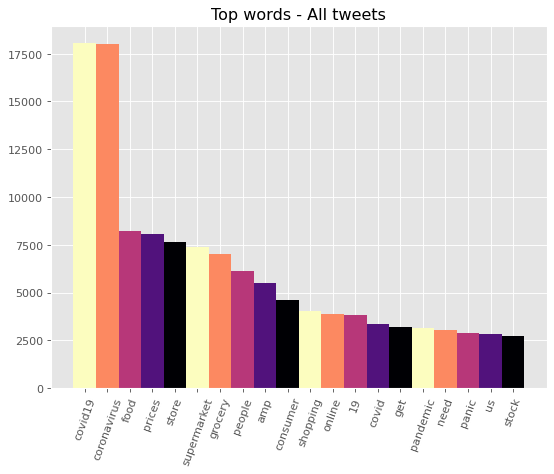

In [44]:
figure(figsize=(8, 6), dpi=80)

labels, values = zip(*top20_nostem)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, values, width, align='center', color=colors)
plt.title("Top words - All tweets")
plt.xticks(xs, labels, rotation=70) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks()

## Comment: It is no surprise that the words covid19, coronavirus are the most used one (because the tweets are about
## covid19). The next most common words are food, prices, store, supermarket, grocery... which do make sense

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text major ticklabel objects>)

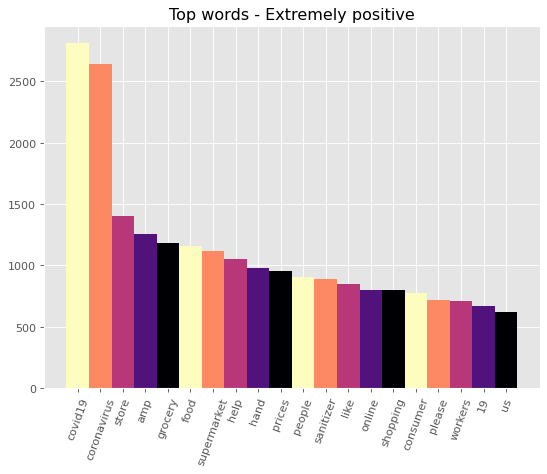

In [45]:
figure(figsize=(8, 6), dpi=80)

labels, values = zip(*top20_expos_nostem)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, values, width, align='center', color=colors)
plt.title("Top words - Extremely positive")
plt.xticks(xs, labels, rotation=70) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks()

### Comment: We show the most used words in Extremely Positive tweets, we see
### words like "help", "like" or "please" which might indicate a positive context

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text major ticklabel objects>)

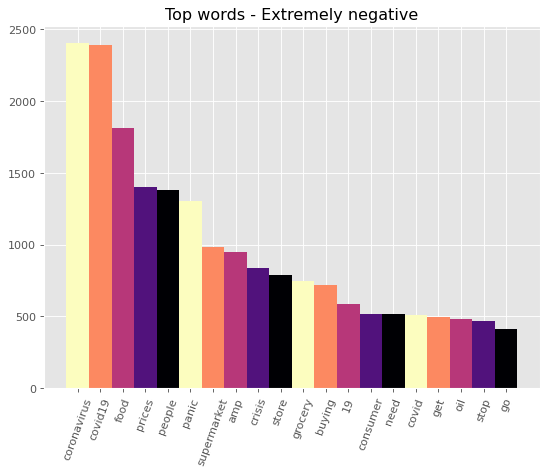

In [46]:
figure(figsize=(8, 6), dpi=80)

labels, values = zip(*top20_exneg_nostem)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, values, width, align='center', color=colors)
plt.title("Top words - Extremely negative")
plt.xticks(xs, labels, rotation=70) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks()

### Comment: We show the most used words in Extremely negative tweets, we see
### words like "panic" and "crisis" which might indicate a negative context

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.]),
 <a list of 9 Text major ticklabel objects>)

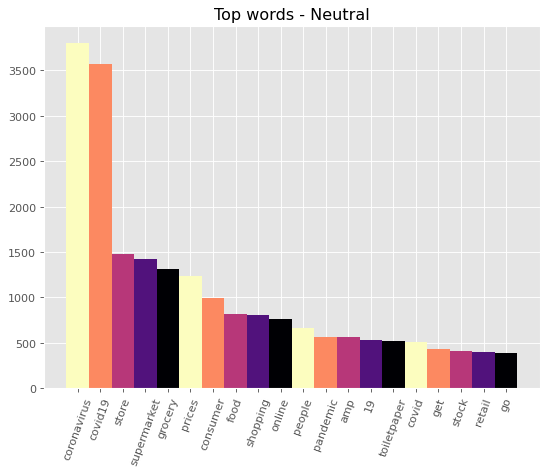

In [47]:
figure(figsize=(8, 6), dpi=80)

labels, values = zip(*top20_neu_nostem)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, values, width, align='center', color=colors)
plt.title("Top words - Neutral")
plt.xticks(xs, labels, rotation=70) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks()

### Comment: We show the most used words in Neutral tweets

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 <a list of 7 Text major ticklabel objects>)

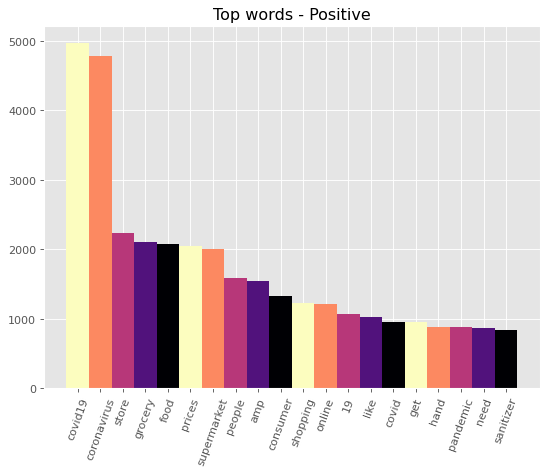

In [48]:
figure(figsize=(8, 6), dpi=80)

labels, values = zip(*top20_pos_nostem)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, values, width, align='center', color=colors)
plt.title("Top words - Positive")
plt.xticks(xs, labels, rotation=70) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks()

### Comment: We show the most used words in Positive tweets

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text major ticklabel objects>)

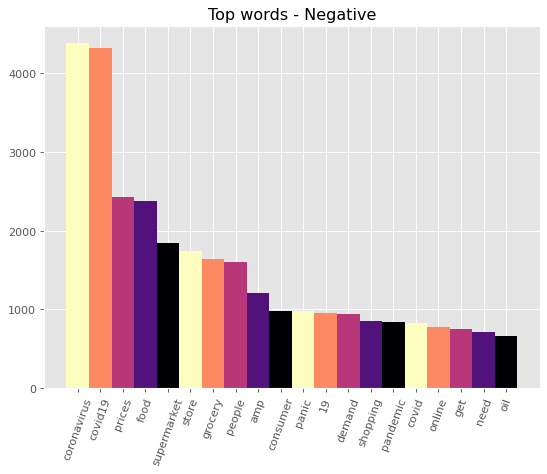

In [49]:
figure(figsize=(8, 6), dpi=80)

labels, values = zip(*top20_neg_nostem)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, values, width, align='center', color=colors)
plt.title("Top words - Negative")
plt.xticks(xs, labels, rotation=70) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks()

### Comment: We show the most used words in Negative tweets

### 2.7 **Obtain** a final tractable dataset with tf-idf on the cleaned dataset

In [50]:
## Untokenize the tweets

from nltk.tokenize.treebank import TreebankWordDetokenizer
detoken = TreebankWordDetokenizer()

detokens_train_cleaned = [detoken.detokenize(tweet) for tweet in train_cleaned['OriginalTweet'] ]
detokens_test_cleaned  = [detoken.detokenize(tweet) for tweet in  test_cleaned['OriginalTweet'] ]
detokens_df_cleaned    = [detoken.detokenize(tweet) for tweet in    df_cleaned['OriginalTweet'] ]

## Replace the columns OriginalTweet with these untokenized vectors

train_cleaned_detokenized = train_cleaned[['OriginalTweet','Sentiment']].copy()
test_cleaned_detokenized  = test_cleaned[['OriginalTweet','Sentiment']].copy()
df_cleaned_detokenized    = df_cleaned[['OriginalTweet','Sentiment']].copy()

train_cleaned_detokenized['OriginalTweet']  = detokens_train_cleaned.copy()
test_cleaned_detokenized['OriginalTweet']   = detokens_test_cleaned.copy()
df_cleaned_detokenized['OriginalTweet']     = detokens_df_cleaned.copy()

In [51]:
train_cleaned_detokenized

OriginalTweet           Sentiment
0                            menyrbie philgahan chrisitv             Neutral
1      advice talk neighbours family exchange phone n...            Positive
2      coronavirus australia woolworths give elderly ...            Positive
3      food stock one emptyplease dont panic enough f...            Positive
4      ready go supermarket covid19 outbreaknot im pa...  Extremely Negative
...                                                  ...                 ...
41152  airline pilots offering stock supermarket shel...             Neutral
41153  response complaint provided citing covid19 rel...  Extremely Negative
41154  know getting tough kameronwilds rationing toil...            Positive
41155  wrong smell hand sanitizer starting turn oncor...             Neutral
41156  tartiicat well newused rift going 70000 amazon...            Negative

[41157 rows x 2 columns]

In [52]:
## Untokenize the tweets for the cleaned with no lemmatizing 

from nltk.tokenize.treebank import TreebankWordDetokenizer
detoken = TreebankWordDetokenizer()

detokens_train_cleaned_lemmatized = [detoken.detokenize(tweet) for tweet in train_cleaned_lemmatized['OriginalTweet'] ]
detokens_test_cleaned_lemmatized  = [detoken.detokenize(tweet) for tweet in  test_cleaned_lemmatized['OriginalTweet'] ]
detokens_df_cleaned_lemmatized    = [detoken.detokenize(tweet) for tweet in    df_cleaned_lemmatized['OriginalTweet'] ]

## Replace the columns OriginalTweet with these untokenized vectors

train_cleaned_detokenized_lemmatized = train_cleaned_lemmatized[['OriginalTweet','Sentiment']].copy()
test_cleaned_detokenized_lemmatized  = test_cleaned_lemmatized[['OriginalTweet','Sentiment']].copy()
df_cleaned_detokenized_lemmatized    = df_cleaned_lemmatized[['OriginalTweet','Sentiment']].copy()

train_cleaned_detokenized_lemmatized['OriginalTweet']  = detokens_train_cleaned_lemmatized.copy()
test_cleaned_detokenized_lemmatized['OriginalTweet']   = detokens_test_cleaned_lemmatized.copy()
df_cleaned_detokenized_lemmatized['OriginalTweet']     = detokens_df_cleaned_lemmatized.copy()

In [53]:
# comparison between a tweet and its lemmatized version
arandom = 100
print(train_cleaned_detokenized_lemmatized['OriginalTweet'][arandom])
print(train_cleaned_detokenized['OriginalTweet'][arandom])

hate grocery shopping general swear im online next shop deal swathe panic buyer covid19 coronavirus coronavirusuk anxiety panicbuyinguk moron
hate grocery shopping general swear im online next shop deal swathes panic buyers covid19 coronavirus coronavirusuk anxiety panicbuyinguk morons


In [54]:
### Define the dimension of interest
number_of_dimensions = 1000

### Creating 1-gram words by tf-idf

tfidf_vectorizer1 = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1), ## we use 1-gram here
    max_features = number_of_dimensions,
    max_df=1.0,
    min_df=10)

tweets = df_cleaned['OriginalTweet'].astype(str)
tfidf_vectorizer1.fit(tweets)

### Creating 1,2-gram  words by tf-idf

vectorized_tweets1 = tfidf_vectorizer1.transform(tweets).toarray()

tfidf_vectorizer12 = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2), ## we use 1-gram and 2-gram here
    max_features = number_of_dimensions,
    max_df=1.0,
    min_df=10)

tfidf_vectorizer12.fit(tweets)

vectorized_tweets = tfidf_vectorizer12.transform(tweets).toarray()



In [55]:
### Two vectorized tweets are different because of our 1 or 2-gram choices
vectorized_tweets1[1] - vectorized_tweets[1] 

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.25310842,  0.        ,  0.25748643,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## 3. Clustering

### 3.1 Latent Dirichlet Allocation (LDA)

In [ ]:
import gensim
from gensim.utils import simple_preprocess

### Create dictionaries, here we will use both cleaned datasets: 1) cleaned and  2) cleaned + lemmatized to see how good lemmatized data can help

dictionary_nostem = gensim.corpora.Dictionary(df_cleaned['OriginalTweet'])
dictionary_lemmatized = gensim.corpora.Dictionary(df_cleaned_lemmatized['OriginalTweet'])

In [ ]:
### Keep only a couple of thousands of most common words because these tweets are mostly about corona virus, so some most frequent words like covid19, covid
### should not be in the dictionary for better clustering

dictionary_nostem.filter_extremes( no_above= 0.4, keep_n=1000) ## We can change the values of parameters here to how different the clusters will be
dictionary_lemmatized.filter_extremes( no_above= 0.4, keep_n=1000)


In [ ]:
### For each document we create a dictionary reporting how many words and how many times those words appear.

corpus_nostem     = [dictionary_nostem.doc2bow(doc) for doc in df_cleaned['OriginalTweet']]
corpus_lemmatized = [dictionary_lemmatized.doc2bow(doc) for doc in df_cleaned_lemmatized['OriginalTweet']]

corpus_lemmatized[1310]

[(18, 1),
 (29, 1),
 (34, 1),
 (130, 2),
 (131, 1),
 (138, 1),
 (279, 1),
 (401, 1),
 (491, 1),
 (559, 1),
 (593, 1)]

In [ ]:
from gensim import corpora, models

## Recreate tfidf in a different way.

tfidf_nostem = models.TfidfModel(corpus_nostem)
tfidf_lemmatized = models.TfidfModel(corpus_lemmatized)

corpus_tfidf_nostem = tfidf_nostem[corpus_nostem]
corpus_tfidf_lemmatized = tfidf_lemmatized[corpus_lemmatized]

corpus_tfidf_nostem[110]

[(17, 0.06790239203679246),
 (40, 0.12583762677541918),
 (116, 0.21037138666833463),
 (167, 0.1843205959012267),
 (274, 0.3160777458468877),
 (297, 0.23056192220971655),
 (344, 0.2542141220851732),
 (445, 0.39044160766434755),
 (456, 0.3965077256263989),
 (542, 0.36107977561693877),
 (543, 0.38738410292101516),
 (544, 0.3058220399977865)]

In [ ]:
### LDA using bags of words: 

lda_model_nostem     = gensim.models.LdaMulticore(corpus_nostem, num_topics= 15, id2word=dictionary_nostem, passes=2, workers=2)
lda_model_lemmatized = gensim.models.LdaMulticore(corpus_lemmatized, num_topics= 15, id2word=dictionary_lemmatized, passes=2, workers=2)


In [ ]:
### Seeing the topics, first for no stemming, lemmatizing model
for idx, topic in lda_model_nostem.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.105*"coronavirus" + 0.091*"covid19" + 0.085*"grocery" + 0.078*"store" + 0.022*"sanitizer" + 0.022*"socialdistancing" + 0.020*"coronaviruspandemic" + 0.018*"corona" + 0.015*"toiletpaper" + 0.014*"pandemic"
Topic: 1 
Words: 0.058*"supermarket" + 0.044*"shelves" + 0.030*"coronavirus" + 0.030*"people" + 0.023*"empty" + 0.017*"local" + 0.016*"covid19" + 0.014*"one" + 0.011*"still" + 0.011*"get"
Topic: 2 
Words: 0.135*"prices" + 0.043*"covid19" + 0.043*"oil" + 0.035*"coronavirus" + 0.022*"market" + 0.016*"low" + 0.012*"trump" + 0.012*"gas" + 0.012*"due" + 0.011*"companies"
Topic: 3 
Words: 0.062*"store" + 0.060*"grocery" + 0.032*"covid19" + 0.032*"coronavirus" + 0.018*"covid2019" + 0.018*"back" + 0.018*"like" + 0.017*"prices" + 0.015*"getting" + 0.012*"people"
Topic: 4 
Words: 0.077*"food" + 0.063*"stock" + 0.035*"coronavirus" + 0.033*"covid19" + 0.031*"amp" + 0.018*"people" + 0.017*"prices" + 0.011*"world" + 0.010*"supply" + 0.010*"panic"
Topic: 5 
Words: 0.040*"amp" + 0.

In [ ]:
### ### Seeing the topics, for lemmatized models

for idx, topic in lda_model_lemmatized.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.053*"home" + 0.046*"stay" + 0.037*"people" + 0.026*"get" + 0.024*"covid19" + 0.022*"work" + 0.019*"safe" + 0.019*"supermarket" + 0.019*"coronavirus" + 0.015*"im"
Topic: 1 
Words: 0.071*"covid19" + 0.066*"price" + 0.043*"coronavirus" + 0.030*"consumer" + 0.020*"pandemic" + 0.014*"report" + 0.012*"market" + 0.012*"product" + 0.011*"impact" + 0.010*"online"
Topic: 2 
Words: 0.039*"price" + 0.033*"coronavirus" + 0.029*"consumer" + 0.027*"covid19" + 0.018*"u" + 0.012*"trump" + 0.011*"amp" + 0.011*"due" + 0.010*"economy" + 0.010*"china"
Topic: 3 
Words: 0.098*"store" + 0.053*"19" + 0.052*"covid" + 0.051*"retail" + 0.037*"grocery" + 0.022*"coronavirus" + 0.020*"covid19" + 0.016*"employee" + 0.016*"open" + 0.012*"closed"
Topic: 4 
Words: 0.042*"food" + 0.040*"covid19" + 0.027*"coronavirus" + 0.020*"shelf" + 0.019*"stock" + 0.018*"pandemic" + 0.016*"market" + 0.015*"news" + 0.013*"supply" + 0.012*"people"
Topic: 5 
Words: 0.086*"price" + 0.037*"oil" + 0.031*"supply" + 0.031*"

In [ ]:
### Evaluation of the model, using an example from the data to see what scores that tweet can have for each topic:
print(df_cleaned['OriginalTweet'][1311])
for index, score in sorted(lda_model_nostem[corpus_nostem[1311]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_nostem.print_topic(index, 10)))

## Comment: it shows the 3 best matched topics for this tweet

['know', 'wondrously', 'diverse', 'multi', 'talented', 'everything', 'americans', 'difficult', 'time', 'forming', 'line', 'grocery', 'store', 'count', 'one', 'believes', 'next', '4', '6', 'weeks', 'may', 'long', 'dark', 'night', 'soul']

Score: 0.6564444303512573	 
Topic: 0.040*"amp" + 0.031*"home" + 0.026*"stay" + 0.025*"people" + 0.022*"food" + 0.020*"2" + 0.016*"must" + 0.015*"1" + 0.014*"19" + 0.012*"help"

Score: 0.1974678933620453	 
Topic: 0.051*"supermarket" + 0.037*"covid19" + 0.036*"people" + 0.019*"coronavirus" + 0.017*"like" + 0.010*"one" + 0.009*"long" + 0.009*"person" + 0.009*"hand" + 0.009*"get"

Score: 0.09902872145175934	 
Topic: 0.058*"supermarket" + 0.044*"shelves" + 0.030*"coronavirus" + 0.030*"people" + 0.023*"empty" + 0.017*"local" + 0.016*"covid19" + 0.014*"one" + 0.011*"still" + 0.011*"get"


In [ ]:
## Let's see how the lemmatized one is doing

for index, score in sorted(lda_model_lemmatized[corpus_lemmatized[1311]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_lemmatized.print_topic(index, 10)))

## Comment: This is a bit different from above


Score: 0.7013441920280457	 
Topic: 0.056*"store" + 0.055*"grocery" + 0.041*"coronavirus" + 0.034*"covid19" + 0.018*"people" + 0.016*"supermarket" + 0.011*"like" + 0.009*"today" + 0.009*"get" + 0.009*"went"

Score: 0.24767529964447021	 
Topic: 0.059*"online" + 0.055*"shopping" + 0.035*"amp" + 0.025*"covid19" + 0.024*"u" + 0.022*"coronavirus" + 0.021*"dont" + 0.020*"need" + 0.019*"people" + 0.014*"know"


In [ ]:
## Now let's see how it calculate the scores for an unseen tweet.

unseen_document = ['i', 'want', 'to', 'buy', 'food', 'but', 'the', 'markets', 'were', 'closed']

bow_vector = dictionary_nostem.doc2bow(unseen_document )

for index, score in sorted(lda_model_nostem[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_nostem.print_topic(index, 5)))

### Comment: It precisely gives the topic based on "food" the largest probability

Score: 0.6450964212417603	 Topic: 0.077*"food" + 0.063*"stock" + 0.035*"coronavirus" + 0.033*"covid19" + 0.031*"amp"
Score: 0.2104589343070984	 Topic: 0.056*"retail" + 0.053*"store" + 0.034*"stores" + 0.033*"covid19" + 0.025*"coronavirus"
Score: 0.01111114677041769	 Topic: 0.055*"panic" + 0.042*"food" + 0.038*"buying" + 0.028*"hand" + 0.027*"sanitizer"
Score: 0.011111144907772541	 Topic: 0.040*"amp" + 0.031*"home" + 0.026*"stay" + 0.025*"people" + 0.022*"food"
Score: 0.011111143976449966	 Topic: 0.031*"shopping" + 0.031*"go" + 0.027*"covid19" + 0.025*"online" + 0.025*"coronavirus"
Score: 0.011111132800579071	 Topic: 0.065*"covid19" + 0.064*"consumer" + 0.036*"coronavirus" + 0.023*"amp" + 0.016*"pandemic"
Score: 0.011111130006611347	 Topic: 0.062*"store" + 0.060*"grocery" + 0.032*"covid19" + 0.032*"coronavirus" + 0.018*"covid2019"
Score: 0.011111129075288773	 Topic: 0.096*"food" + 0.066*"19" + 0.062*"covid" + 0.043*"demand" + 0.021*"covid19"
Score: 0.011111126281321049	 Topic: 0.051*"su

### 3.2 K-means

#### Direct K-means without dimension reduction

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
### Direct K-means implementations, we believe that these tweets will have many different topics (around 15-35) so we implement
### K-means with different choices of the number of clusters and use the Elbow method to determine what number of clusters we should choose

kmeans_kwargs = {"init": "random","n_init": 5,"max_iter": 3000, "random_state": 42,} ## K-means model
klist = [5, 7, 9, 12, 14,17, 20] ## Because dimensions is too big so this is a better way to run
sse  = [] # A list that holds the SSE values for each k
sse1 = []

for k in klist:
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(vectorized_tweets)
  sse.append(kmeans.inertia_)
  kmeans.fit(vectorized_tweets1)
  sse1.append(kmeans.inertia_)

### This takes about some time

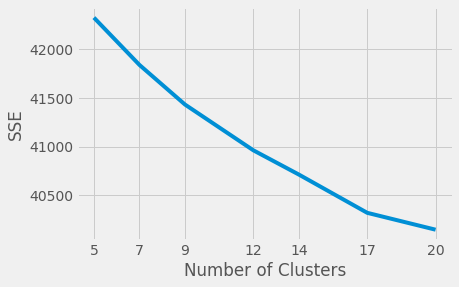

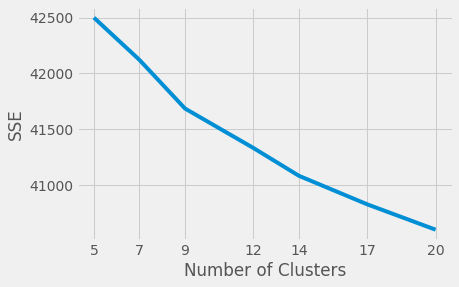

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(klist, sse)
plt.xticks(klist)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

plt.style.use("fivethirtyeight")
plt.plot(klist, sse1)
plt.xticks(klist)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Comment: Direct K-means on vectorized tweets is not efficient, the SSE is decreasing in a linear line and it's not stable even after many choices
### of number of clusters

In [ ]:
# using 15 clusters
kmeans = KMeans(n_clusters=15, **kmeans_kwargs)
kmeans.fit(vectorized_tweets1)

# connecting cluster IDs with the tweets
kmeans_d = { 'ClusterID': kmeans.labels_.astype(int)}
kmeans_d = pd.DataFrame(data=kmeans_d)
kmeans_d.tail(5)

ClusterID
44950          4
44951          1
44952          6
44953          4
44954          6

In [ ]:
# the dataset with Kmeans cluster IDs
df_cleaned_clusterKmeans = pd.concat([df_cleaned, kmeans_d ], axis = 1)
df_cleaned_clusterKmeans.head(5)

UserName  ScreenName   Location  ... length Location_Clean ClusterID
0      3799       48751     London  ...    111         London         6
1      3800       48752         UK  ...    237             UK        14
2      3801       48753  Vagabonds  ...    131      Vagabonds        14
3      3802       48754        NaN  ...    306            NaN         8
4      3803       48755        NaN  ...    310            NaN         1

[5 rows x 12 columns]

In [ ]:
# Comment: We show sentiment counts in each cluster. some clusters are mainly negative or positive, some of them larger than others
class_df_clusterKmeans = df_cleaned_clusterKmeans.groupby(['ClusterID','Sentiment']).count()['OriginalTweet'].reset_index().sort_values(by=['ClusterID', 'OriginalTweet'],ascending=False)
class_df_clusterKmeans.style.background_gradient(cmap='magma')

In [ ]:
df_cleaned_clusterKMeans_cloud = df_cleaned_clusterKmeans.copy()
df_cleaned_clusterKMeans_cloud['OriginalTweet'] = pd.Series(df_cleaned_clusterKmeans['OriginalTweet'], dtype="string")
df_cleaned_clusterKMeans_cloud.dtypes

UserName                   int64
ScreenName                 int64
Location                  object
TweetAt           datetime64[ns]
OriginalTweet             string
Sentiment                 object
month                      int64
year                       int64
month_year        datetime64[ns]
length                     int64
Location_Clean            object
ClusterID                  int64
dtype: object

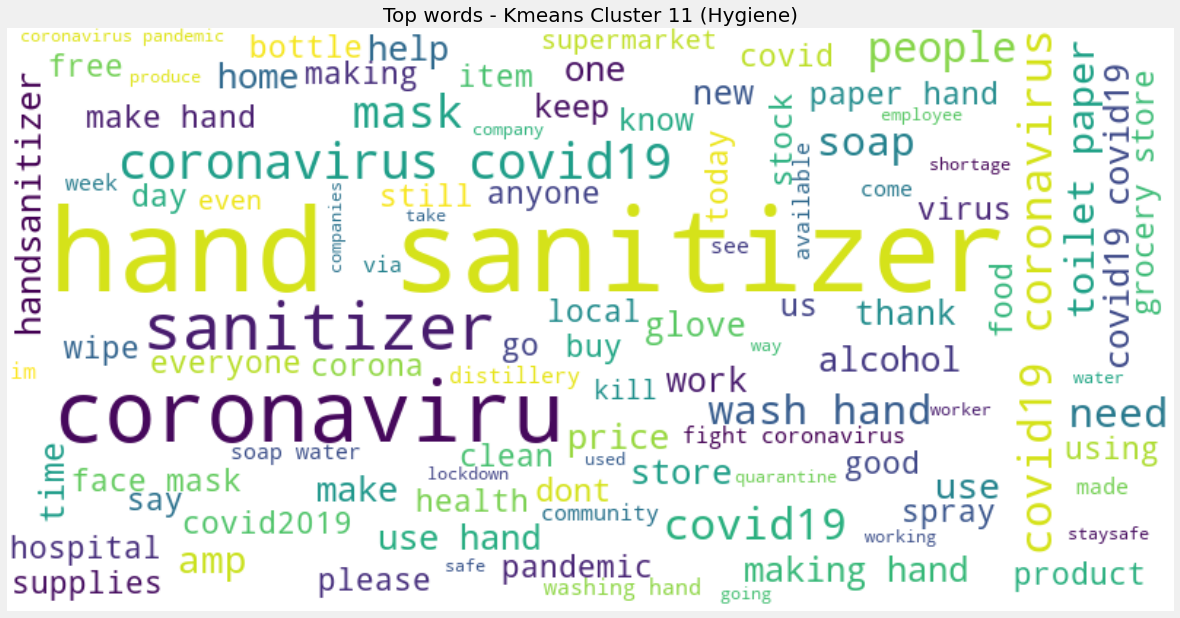

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      max_words=100)

wordcloud.generate(' '.join(text for text in df_cleaned_clusterKMeans_cloud[(df_cleaned_clusterKMeans_cloud.ClusterID == 11)]['OriginalTweet'].str.replace("'", "")))

plt.figure(figsize=(20,10))
plt.title("Top words - Kmeans Cluster 11 (Hygiene)", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

### Comment: Aside from being a mainly positive cluster of tweets, this cluster
### seems to be mainly about hygiene. This is what we aimed to achieve with
### tweets of similar topics being clustered together.

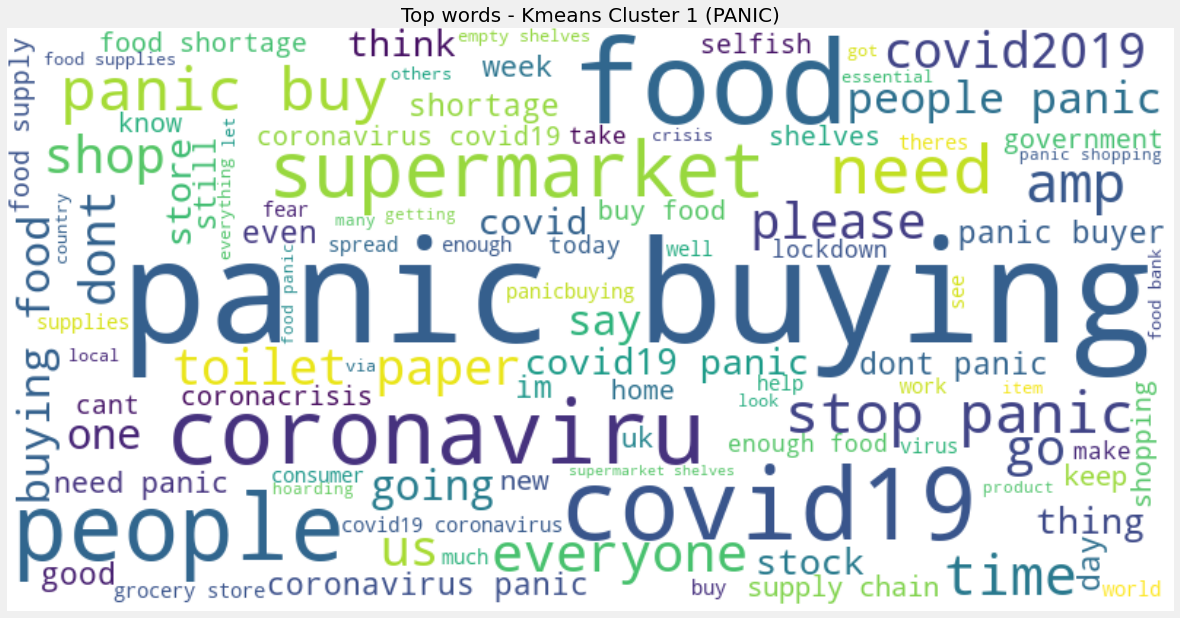

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      max_words=100)

wordcloud.generate(' '.join(text for text in df_cleaned_clusterKMeans_cloud[(df_cleaned_clusterKMeans_cloud.ClusterID == 1)]['OriginalTweet'].str.replace("'", "")))

plt.figure(figsize=(20,10))
plt.title("Top words - Kmeans Cluster 1 (PANIC)", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

### Comment: Aside from being a mainly negative cluster of tweets, this cluster
### seems to be mainly about panic buying groceries or other essential items.

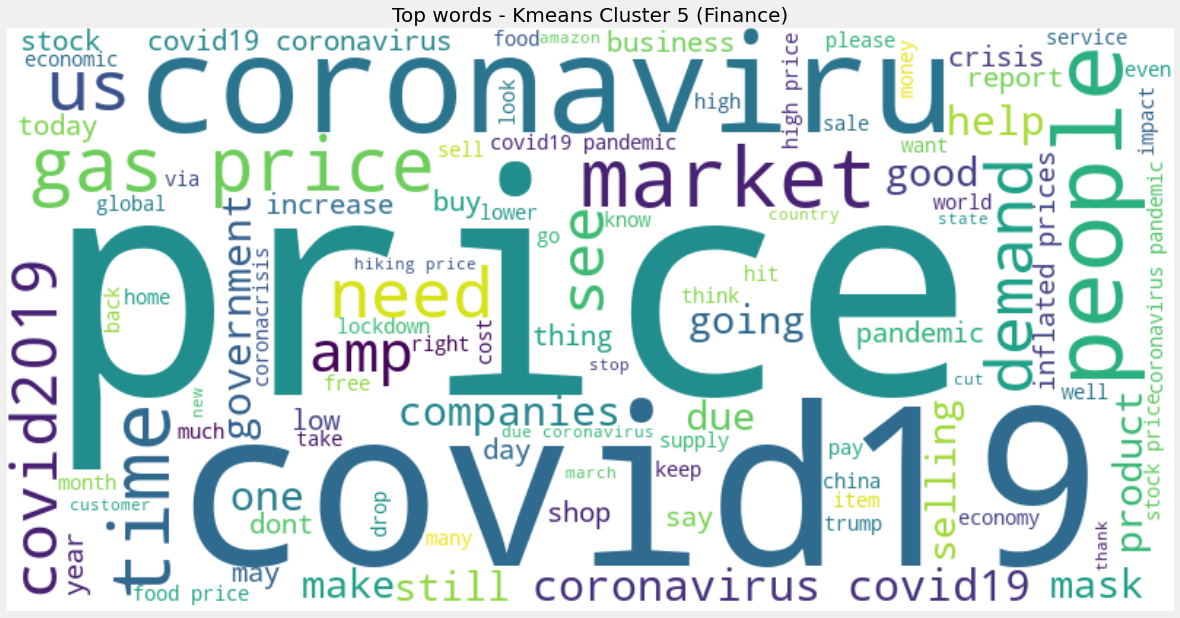

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      max_words=100)

wordcloud.generate(' '.join(text for text in df_cleaned_clusterKMeans_cloud[(df_cleaned_clusterKMeans_cloud.ClusterID == 5)]['OriginalTweet'].str.replace("'", "")))

plt.figure(figsize=(20,10))
plt.title("Top words - Kmeans Cluster 5 (Finance)", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

### Comment: Aside from being a mixed cluster of tweets, this cluster
### seems to be mainly about the financial aspect of the covid19. Tweets about
### stock and commodity prices, governments and companies and other financial
### terms seem to be gathered in this cluster.

#### K-means using PCA to reduce dimension

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(vectorized_tweets)

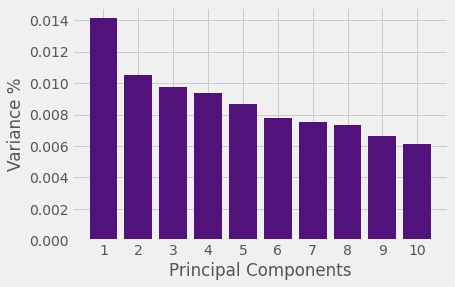

In [ ]:
# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='#51127c')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

### Comment: Using PCA to reduce dimensions might be impossible here.

### 3.3 Clustering using NMF

In [ ]:
from sklearn.decomposition import NMF

### Suppose that we want to cluster the corpus into 15 different clusters/profiles

nmf_model = NMF(n_components = 15, init='random', random_state=0, max_iter = 400)
W = nmf_model.fit_transform(vectorized_tweets)
H = nmf_model.components_

W[0:8]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.51415438e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.98468100e-04, 2.40218959e-04, 3.09961840e-04,
        2.27921634e-02, 8.76542899e-03, 0.00000000e+00, 8.56743355e-03,
        0.00000000e+00, 0.00000000e+00, 3.16103561e-03],
       [5.27686272e-03, 1.31212304e-01, 1.24510776e-02, 1.06883778e-01,
        8.51787594e-03, 2.51004818e-03, 1.41512778e-02, 1.33847878e-03,
        0.00000000e+00, 2.08152358e-03, 0.00000000e+00, 7.11210350e-03,
        5.99282323e-02, 1.13497201e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.98289064e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.74499068e-01, 0.00000000e+0

In [ ]:
from sklearn.preprocessing import normalize

### Normalize the rows of the W matrix with l1, so the sum of them will equal to 1, each coordinate can represents the probability of being in the profile
### corresponding to that coordinate, we then assign the tweets to the profile with largest probability.

normalized_W = normalize(W, 'l1')
print(np.sum(normalized_W[2]))

### Assign each tweet to each profile/cluster/topics.

clusterNMF_id = np.zeros(W.shape[0] )

for i in range(W.shape[0]):
  clusterNMF_id[i] =  np.where(W[i] == np.max(W[i]))[0][0]

### Let's see the unique values of the clusters

print(np.unique(clusterNMF_id))


0.9999999999999998
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [ ]:
d = { 'ClusterID': clusterNMF_id.astype(int)}
d = pd.DataFrame(data=d)
d.tail(10)

ClusterID
44945         11
44946          7
44947          4
44948          9
44949          8
44950          2
44951         11
44952         12
44953          2
44954          3

In [ ]:
### Creating a dataset with cleaned tweets + Cluster ID

df_cleaned_clusterNMF = pd.concat([df_cleaned, d ], axis = 1)

In [ ]:
df_cleaned_clusterNMF.head()
df_cleaned_clusterNMF.dtypes

UserName                   int64
ScreenName                 int64
Location                  object
TweetAt           datetime64[ns]
OriginalTweet             object
Sentiment                 object
month                      int64
year                       int64
month_year        datetime64[ns]
length                     int64
Location_Clean            object
ClusterID                  int64
dtype: object

In [ ]:
### Let's take a look at the sentiment counts in each clusterID

class_df_clusterNMF = df_cleaned_clusterNMF.groupby(['ClusterID','Sentiment']).count()['OriginalTweet'].reset_index().sort_values(by=['ClusterID', 'OriginalTweet'],ascending=False)
class_df_clusterNMF.style.background_gradient(cmap='magma')

In [ ]:
## Prepare a dataset for drawing wordcloud, to see which words are used most commonly

df_cleaned_clusterNMF_cloud = df_cleaned_clusterNMF.copy()
df_cleaned_clusterNMF_cloud['OriginalTweet'] = pd.Series(df_cleaned_clusterNMF['OriginalTweet'], dtype="string")
df_cleaned_clusterNMF_cloud.dtypes

UserName                   int64
ScreenName                 int64
Location                  object
TweetAt           datetime64[ns]
OriginalTweet             string
Sentiment                 object
month                      int64
year                       int64
month_year        datetime64[ns]
length                     int64
Location_Clean            object
ClusterID                  int64
dtype: object

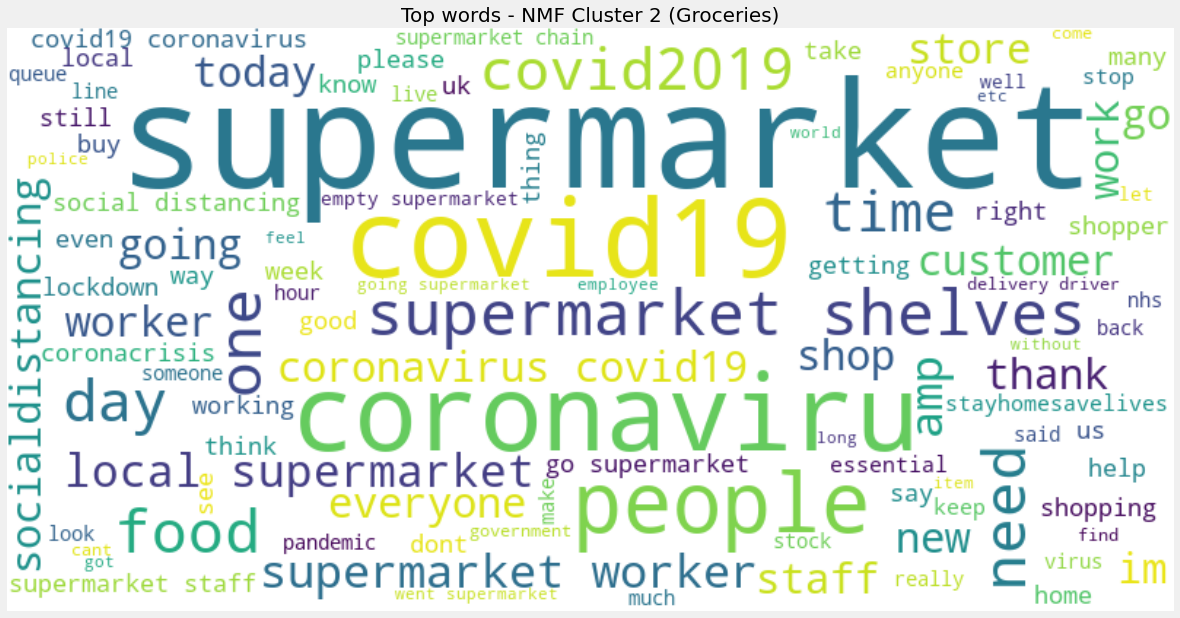

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      max_words=100)

wordcloud.generate(' '.join(text for text in df_cleaned_clusterNMF_cloud[(df_cleaned_clusterNMF_cloud.ClusterID == 2)]['OriginalTweet'].str.replace("'", "")))

plt.figure(figsize=(20,10))
plt.title("Top words - NMF Cluster 2 (Groceries)", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

## Comment: This topic is mostly about "go shopping in the pandemic", we can see "customer", "supermarket", "local supermarket",
## "social distancing", "good"

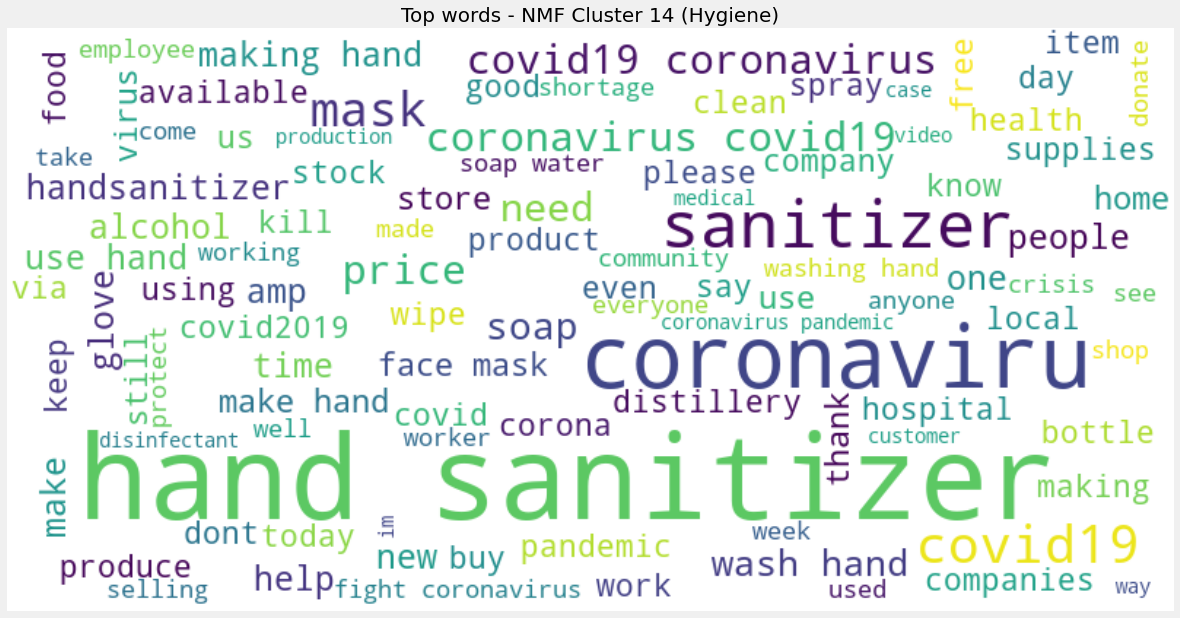

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      max_words=100)

wordcloud.generate(' '.join(text for text in df_cleaned_clusterNMF_cloud[(df_cleaned_clusterNMF_cloud.ClusterID == 14)]['OriginalTweet'].str.replace("'", "")))

plt.figure(figsize=(20,10))
plt.title("Top words - NMF Cluster 14 (Hygiene)", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

## Comment: It seems that this topic os about "preventing virus infection", we can see "hand sanitizer", "mask", "washing hands"
## this is interesting because it seems that NMF do a great job clustering these tweets together

#### Additional: How to determine the number of profiles for NMF using dispersion coefficients (according to *Kim[07]*)

In [ ]:
## This part is dedicated to find the optimal/resonable number of profiles based on dispersion coefficient in Kim (07) paper
## Define a function to calculate a vector of dispersion coefficients for each number of profiles

def assign_clusters(matrixW):
  cluster_id = np.zeros( matrixW.shape[0] )
  for i in range(w.shape[0]):
    cluster_id[i] =  np.where(matrixW[i] == np.max(matrixW[i]))[0][0]
  return cluster_id

## A function to calculate a vector of dispersion coefficients for each number of profiles in alist, data is our data of tf-idf

def dis_coef(alist, data): 
  dis_coefficients = []
  for k in alist:
    nmf_model = NMF(n_components = k, init='random', random_state=0)
    W = nmf_model.fit_transform(data)
    #H = nmf_model.components_
    cluster_id = assign_clusters(W)
    n = W.shape[0]
    a = np.zeros( (n, n ) )
    for j in range(a.shape[0]):
      for i in range(a.shape[0]):
        if cluster_id[i] == cluster_id[j]: 
          a[j,i] = 1
    t = np.sum( np.sum((a-1/2)**2) )*4/ (n**2)
    dis_coefficients.append(t)
  return dis_coefficients

## However, the data is too big so we can not run these lines of codes, for example, the matrix a is 45000 x 45000, so creating
## a concensus matrix and then calculate the dispersion coefficients will take very very long.

#### Kmeans after dimension reduction by NMF

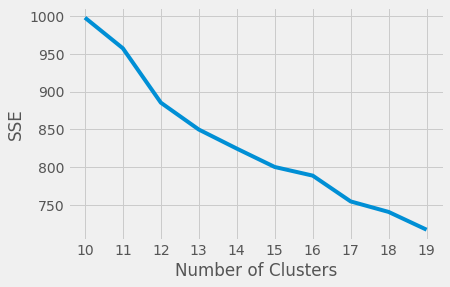

In [ ]:
kmeans_kwargs = {"init": "random","n_init": 5,"max_iter": 3000, "random_state": 42,}

## A list holds the SSE values for each k

sse = []
for k in range(10, 20):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(W)
  sse.append(kmeans.inertia_)

### Plot again the sse

plt.style.use("fivethirtyeight")
plt.plot(range(10, 20), sse)
plt.xticks(range(10, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
# using 15 clusters
kmeans = KMeans(n_clusters=15, **kmeans_kwargs)
kmeans.fit(W)

# connecting cluster IDs with the tweets
NMF_kmeans_d = { 'ClusterID': kmeans.labels_.astype(int)}
NMF_kmeans_d = pd.DataFrame(data=NMF_kmeans_d)
NMF_kmeans_d.tail(5)

ClusterID
44950          6
44951          7
44952          5
44953          6
44954          8

In [ ]:
# the dataset with Kmeans cluster IDs
df_cleaned_NMF_clusterKmeans = pd.concat([df_cleaned, NMF_kmeans_d ], axis = 1)
df_cleaned_NMF_clusterKmeans.head(5)

UserName  ScreenName   Location  ... length Location_Clean ClusterID
0      3799       48751     London  ...    111         London         5
1      3800       48752         UK  ...    237             UK        14
2      3801       48753  Vagabonds  ...    131      Vagabonds         8
3      3802       48754        NaN  ...    306            NaN         7
4      3803       48755        NaN  ...    310            NaN         4

[5 rows x 12 columns]

In [ ]:
# Comment: We show sentiment counts with Kmeans on the NMF'd data, in each cluster. some clusters are mainly negative or positive, some of them larger than others
class_df_NMF_clusterKmeans = df_cleaned_NMF_clusterKmeans.groupby(['ClusterID','Sentiment']).count()['OriginalTweet'].reset_index().sort_values(by=['ClusterID', 'OriginalTweet'],ascending=False)
class_df_NMF_clusterKmeans.style.background_gradient(cmap='magma')

In [ ]:
df_cleaned_NMF_clusterKMeans_cloud = df_cleaned_NMF_clusterKmeans.copy()
df_cleaned_NMF_clusterKMeans_cloud['OriginalTweet'] = pd.Series(df_cleaned_NMF_clusterKmeans['OriginalTweet'], dtype="string")
df_cleaned_NMF_clusterKMeans_cloud.dtypes

UserName                   int64
ScreenName                 int64
Location                  object
TweetAt           datetime64[ns]
OriginalTweet             string
Sentiment                 object
month                      int64
year                       int64
month_year        datetime64[ns]
length                     int64
Location_Clean            object
ClusterID                  int64
dtype: object

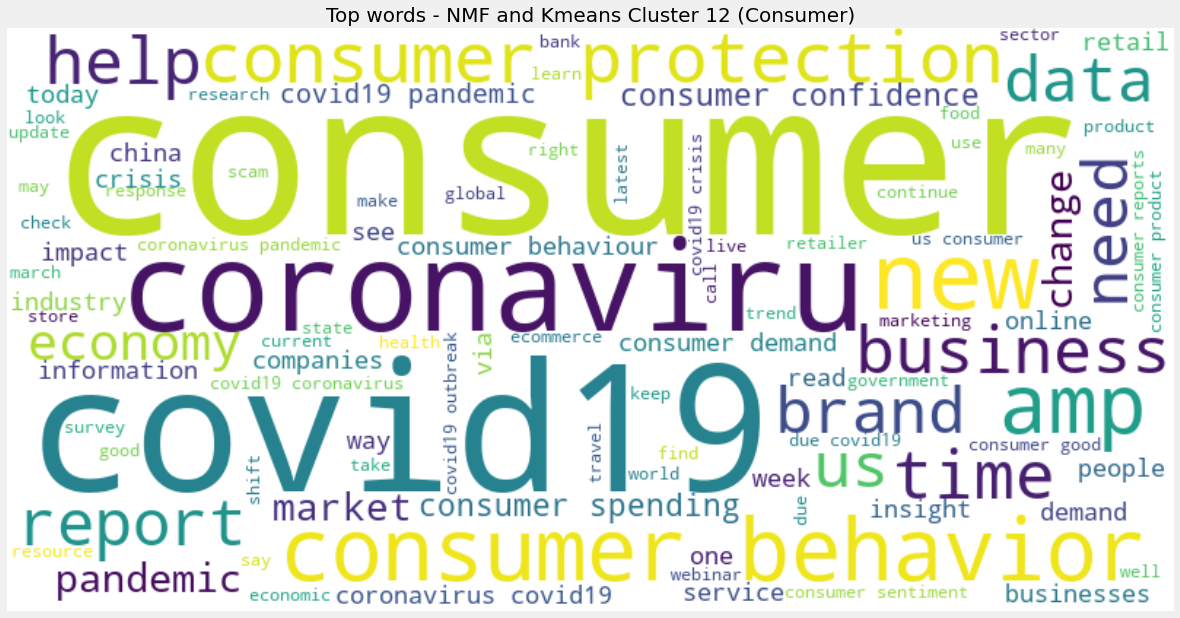

In [ ]:
# let's take a look at cluster number 5
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      max_words=100)

wordcloud.generate(' '.join(text for text in df_cleaned_NMF_clusterKMeans_cloud[(df_cleaned_NMF_clusterKMeans_cloud.ClusterID == 12)]['OriginalTweet'].str.replace("'", "")))

plt.figure(figsize=(20,10))
plt.title("Top words - NMF and Kmeans Cluster 12 (Consumer)", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

### Comment: A cluster of mixed sentiments. All sorts of tweets related to
### consumer behaviour and spending during the crisis.

## 4. Sentiment analysis and inference


### 4.1 Part I: Deep learning neural network model with 1-gram data

In [56]:
## Import packages needed to run

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [60]:
### Define the dimension
number_of_dimensions = 1000

### Create training set
x_train = train_cleaned_detokenized['OriginalTweet'].copy()
y_train = train_cleaned_detokenized['Sentiment'].copy()

### Creat training set with lemmatized words
x_train_lemmatized = train_cleaned_detokenized_lemmatized['OriginalTweet'].copy()
y_train_lemmatized = train_cleaned_detokenized_lemmatized['Sentiment'].copy()

### Take out the test set
x_test  = test_cleaned_detokenized['OriginalTweet'].copy()
y_test  = test_cleaned_detokenized['Sentiment'].copy()

### Test sets with lemmatized words
x_test_lemmatized  = test_cleaned_detokenized_lemmatized['OriginalTweet'].copy()
y_test_lemmatized  = test_cleaned_detokenized_lemmatized['Sentiment'].copy()


### We try 1 gram words in this section
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1), ### Using 1 gram words
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)

tfidf_vectorizer_lemmatized = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)

### Fit the model
tfidf_vectorizer.fit(x_train)
tfidf_vectorizer_lemmatized.fit(x_train_lemmatized)

### Turn the train set to arrays
x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_train_lemmatized_features = tfidf_vectorizer_lemmatized.transform(x_train_lemmatized).toarray()

### Similarly to test set
x_test_features  = tfidf_vectorizer.transform(x_test).toarray()
x_test_lemmatized_features = tfidf_vectorizer_lemmatized.transform(x_test_lemmatized).toarray()



In [61]:
### Modify Sentiments to only 3 categories "Positive", "Neutral", "Negative" because we think this is more efficient,

y_train[y_train == 'Extremely Positive'] = 'Positive'
y_train[y_train == 'Extremely Negative'] = 'Negative'

y_test[y_test == 'Extremely Positive'] = 'Positive'
y_test[y_test == 'Extremely Negative'] = 'Negative'

y_train[0:20]

0      Neutral
1     Positive
2     Positive
3     Positive
4     Negative
5     Positive
6     Positive
7      Neutral
8     Positive
9     Negative
10     Neutral
11    Positive
12    Positive
13    Positive
14    Positive
15    Positive
16     Neutral
17     Neutral
18    Positive
19    Positive
Name: Sentiment, dtype: object

In [62]:
# Define function to display loss and accuracy evolution during training
def plot_history(hist):
  plt.plot(hist.history['loss'], label='train')
  plt.plot(hist.history['val_loss'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Loss evolution')
  plt.show()
  plt.plot(hist.history['accuracy'], label='train')
  plt.plot(hist.history['val_accuracy'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Accuracy evolution')
  plt.show()

# define function to evaluate model performances

def model_evaluation(NN_model, x_test, y_test):
  labels = [0, 1 , 2]  ### we have 3 labels of sentiments to evaluate
  y_pred_proba = NN_model.predict(x_test_features, verbose=1)
  y_pred = [ labels[np.where( i == np.max(i))[0][0] ] for i in y_pred_proba  ] ### Choose the label with largest proba
  print('accuracy {}'.format(round(accuracy_score(y_test, y_pred), 4))) ## accuracy score
  print('f1 macro {}'.format(round(f1_score(y_test, y_pred, average='weighted'), 4))) ### f1 score

In [63]:
encoder = LabelEncoder()

fit_train = encoder.fit(y_train)
fit_test = encoder.fit(y_test)

### encoded the sentiments into different categories

encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

### convert integers to dummy variables (i.e. one hot encoded)

dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)


#### 4.1.1 A model using SGD as the optimizer

In [ ]:
# Creating a neural network model, Sequential model

model = Sequential()
model.add(Dense(128 , activation= 'relu', input_shape=(1000, )))
model.add(Dense(64 , activation= 'relu'))
model.add(Dense(3, activation= 'sigmoid')) ## best to use sigmoid here

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               128128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 136,579
Trainable params: 136,579
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
579/579 [==============================] - 3s 4ms/step - loss: 1.0502 - accuracy: 0.4357 - val_loss: 1.0468 - val_accuracy: 0.4543
Epoch 2/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0390 - accuracy: 0.4367 - val_loss: 1.0450 - val_accuracy: 0.4543
Epoch 3/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0364 - accuracy: 0.4368 - val_loss: 1.0420 - val_accuracy: 0.4548
Epoch 4/20
579/579 [==============================] - 2s 3ms/step - loss: 1.0332 - accuracy: 0.4376 - val_loss: 1.0376 - val_accuracy: 0.4546
Epoch 5/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0290 - accuracy: 0.4399 - val_loss: 1.0344 - val_accuracy: 0.4606
Epoch 6/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0235 - accuracy: 0.4524 - val_loss: 1.0272 - val_accuracy: 0.4721
Epoch 7/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0157 - accuracy: 0.4781 - val_loss: 1.0178 - val_accuracy: 0.4910
Epoch 

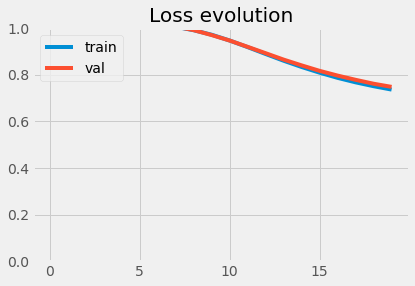

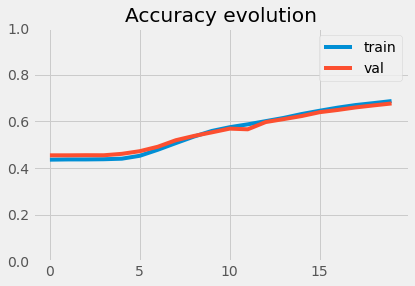

119/119 [==============================] - 0s 1ms/step
accuracy 0.6698
f1 macro 0.6584


In [ ]:
### Create a history to see the evolution of the accuracy on the test set

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs=20, verbose=1, validation_split=0.1)

### Plot the evolutions of loss and accuracy

plot_history(history)

### Check the performance on the test set

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

Epoch 1/20
579/579 [==============================] - 2s 3ms/step - loss: 1.0495 - accuracy: 0.4916 - val_loss: 0.9738 - val_accuracy: 0.5296
Epoch 2/20
579/579 [==============================] - 2s 3ms/step - loss: 0.9396 - accuracy: 0.5527 - val_loss: 0.9186 - val_accuracy: 0.5649
Epoch 3/20
579/579 [==============================] - 2s 3ms/step - loss: 0.8879 - accuracy: 0.5891 - val_loss: 0.8842 - val_accuracy: 0.5850
Epoch 4/20
579/579 [==============================] - 2s 3ms/step - loss: 0.8505 - accuracy: 0.6149 - val_loss: 0.8495 - val_accuracy: 0.6074
Epoch 5/20
579/579 [==============================] - 2s 3ms/step - loss: 0.8202 - accuracy: 0.6342 - val_loss: 0.8241 - val_accuracy: 0.6278
Epoch 6/20
579/579 [==============================] - 2s 3ms/step - loss: 0.7944 - accuracy: 0.6501 - val_loss: 0.8029 - val_accuracy: 0.6356
Epoch 7/20
579/579 [==============================] - 2s 3ms/step - loss: 0.7723 - accuracy: 0.6629 - val_loss: 0.7842 - val_accuracy: 0.6475
Epoch 

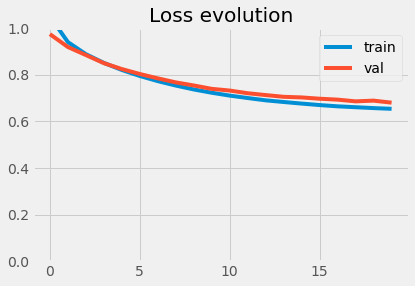

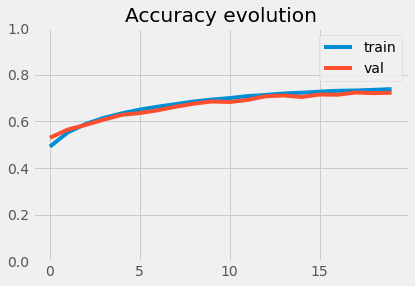

119/119 [==============================] - 0s 2ms/step
accuracy 0.5
f1 macro 0.4955


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

## Using the lemmatized data is not as good as the not lemmatized one, the prediction on the test set is just 47% accurate

#### 4.1.2 A model using SGD with momentum

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 150)               150150    
                                                                 
 dense_4 (Dense)             (None, 80)                12080     
                                                                 
 dense_5 (Dense)             (None, 3)                 243       
                                                                 
Total params: 162,473
Trainable params: 162,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
515/515 [==============================] - 3s 5ms/step - loss: 1.0431 - accuracy: 0.4301 - val_loss: 1.0465 - val_accuracy: 0.4642
Epoch 2/20
515/515 [==============================] - 2s 4ms/step - loss: 1.0423 - accuracy: 0.4309 - val_loss: 1.0508 - val_accuracy: 0.4642
Epoch 3/20
515/515 [========

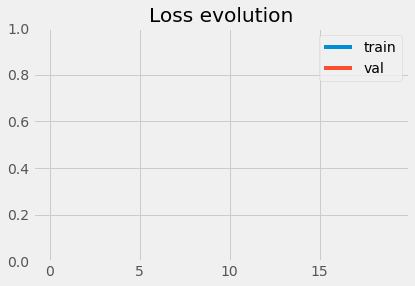

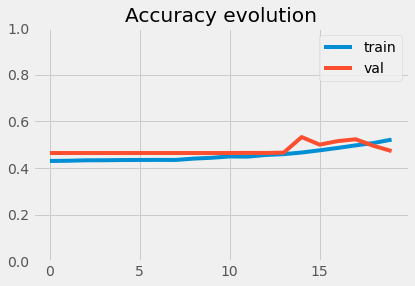

119/119 [==============================] - 0s 2ms/step
accuracy 0.4236
f1 macro 0.2732


In [ ]:
from tensorflow.keras import optimizers

model = Sequential()
model.add(Dense(150, activation='relu', input_shape=(number_of_dimensions,)))
model.add(Dense(80, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))

sgd = optimizers.SGD(momentum= 0.3)
model.compile(
    loss='categorical_crossentropy',
    optimizer= sgd ,
    metrics=['accuracy'])

model.summary()

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs=20, verbose=1, validation_split=0.2)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

### Comment: This optimizer with momentum does not perform well, the scores are accuracy 0.4516, f1 macro 0.3292

Epoch 1/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0368 - accuracy: 0.4463 - val_loss: 1.0409 - val_accuracy: 0.4628
Epoch 2/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0326 - accuracy: 0.4566 - val_loss: 1.0372 - val_accuracy: 0.4657
Epoch 3/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0283 - accuracy: 0.4705 - val_loss: 1.0347 - val_accuracy: 0.5044
Epoch 4/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0235 - accuracy: 0.4878 - val_loss: 1.0288 - val_accuracy: 0.4813
Epoch 5/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0175 - accuracy: 0.5014 - val_loss: 1.0231 - val_accuracy: 0.5192
Epoch 6/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0107 - accuracy: 0.5156 - val_loss: 1.0174 - val_accuracy: 0.5367
Epoch 7/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0026 - accuracy: 0.5331 - val_loss: 1.0055 - val_accuracy: 0.5097
Epoch 

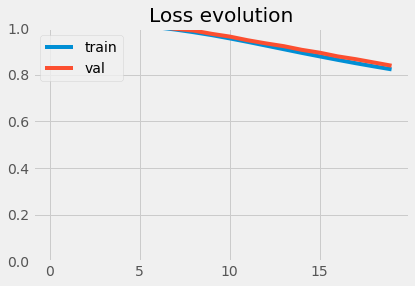

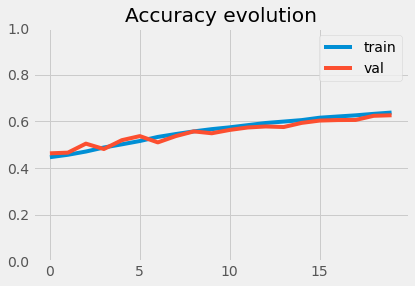

119/119 [==============================] - 0s 2ms/step
accuracy 0.5224
f1 macro 0.4754


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

## Comment: somehow the lemmatized data does better for this model but still too bad, acurray and f1 scores are around 50%

#### 4.1.3 A model using RMSProp (Root Mean Square Propagation)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               128128    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 136,579
Trainable params: 136,579
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
579/579 [==============================] - 3s 5ms/step - loss: 0.7685 - accuracy: 0.6608 - val_loss: 0.6803 - val_accuracy: 0.7162
Epoch 2/15
579/579 [==============================] - 2s 4ms/step - loss: 0.6526 - accuracy: 0.7345 - val_loss: 0.6573 - val_accuracy: 0.7296
Epoch 3/15
579/579 [========

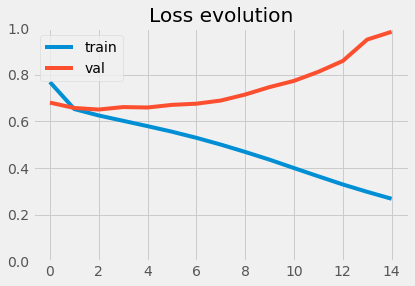

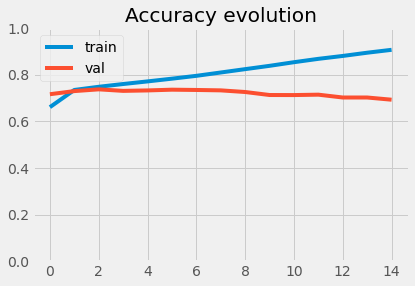

119/119 [==============================] - 0s 1ms/step
accuracy 0.6859
f1 macro 0.6825


In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer = 'rmsprop' ,
    metrics=['accuracy'])

model.summary()

### epochs should not be too large because of overfit.
history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs = 15, verbose=1, validation_split = 0.1)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

## Comment: this model works pretty well, 68% accuray and 68% f1 score

Epoch 1/20
579/579 [==============================] - 3s 5ms/step - loss: 0.8373 - accuracy: 0.6273 - val_loss: 0.7140 - val_accuracy: 0.7017
Epoch 2/20
579/579 [==============================] - 3s 4ms/step - loss: 0.6546 - accuracy: 0.7346 - val_loss: 0.6901 - val_accuracy: 0.7233
Epoch 3/20
579/579 [==============================] - 3s 5ms/step - loss: 0.6080 - accuracy: 0.7605 - val_loss: 0.6916 - val_accuracy: 0.7276
Epoch 4/20
579/579 [==============================] - 3s 4ms/step - loss: 0.5714 - accuracy: 0.7778 - val_loss: 0.6945 - val_accuracy: 0.7252
Epoch 5/20
579/579 [==============================] - 3s 4ms/step - loss: 0.5382 - accuracy: 0.7940 - val_loss: 0.7053 - val_accuracy: 0.7264
Epoch 6/20
579/579 [==============================] - 2s 4ms/step - loss: 0.5049 - accuracy: 0.8080 - val_loss: 0.7201 - val_accuracy: 0.7201
Epoch 7/20
579/579 [==============================] - 3s 4ms/step - loss: 0.4709 - accuracy: 0.8221 - val_loss: 0.7283 - val_accuracy: 0.7242
Epoch 

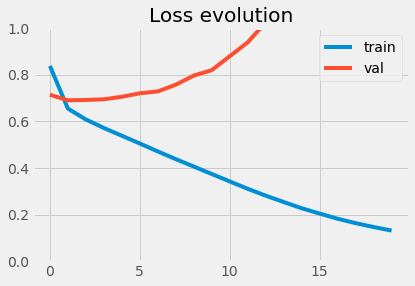

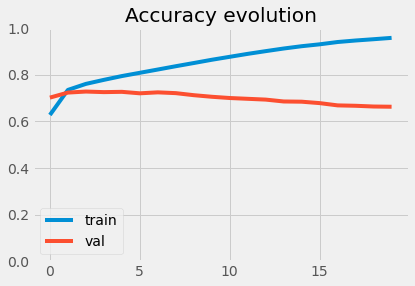

119/119 [==============================] - 0s 1ms/step
accuracy 0.4487
f1 macro 0.4401


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

## Comment: However the scores for lemmatized data are just too bad

In [ ]:
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

119/119 [==============================] - 0s 1ms/step
accuracy 0.4487
f1 macro 0.4401


#### 4.1.4 A model with adam as optimizer + dropout 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               128128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 136,579
Trainable params: 136,579
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
579/579 [============================

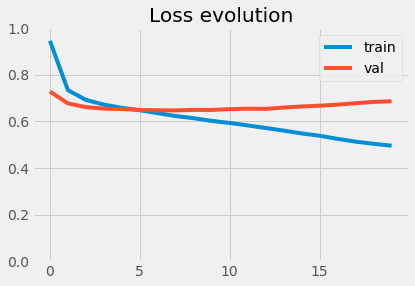

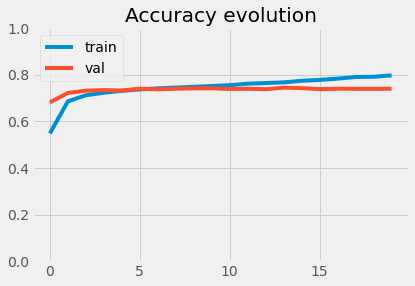

119/119 [==============================] - 0s 1ms/step
accuracy 0.7067
f1 macro 0.7086


In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam' ,
    metrics=['accuracy'])

model.summary()

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs = 20, verbose=1, validation_split = 0.1)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

### Comment: the best model with lower runtime + better scores around 72% when I run this cell

Epoch 1/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0396 - accuracy: 0.4714 - val_loss: 0.9518 - val_accuracy: 0.5243
Epoch 2/20
579/579 [==============================] - 2s 4ms/step - loss: 0.9236 - accuracy: 0.5403 - val_loss: 0.8666 - val_accuracy: 0.5960
Epoch 3/20
579/579 [==============================] - 2s 4ms/step - loss: 0.8312 - accuracy: 0.6098 - val_loss: 0.7891 - val_accuracy: 0.6499
Epoch 4/20
579/579 [==============================] - 2s 4ms/step - loss: 0.7561 - accuracy: 0.6650 - val_loss: 0.7352 - val_accuracy: 0.6888
Epoch 5/20
579/579 [==============================] - 2s 4ms/step - loss: 0.7011 - accuracy: 0.6986 - val_loss: 0.7051 - val_accuracy: 0.7072
Epoch 6/20
579/579 [==============================] - 2s 4ms/step - loss: 0.6619 - accuracy: 0.7227 - val_loss: 0.6894 - val_accuracy: 0.7201
Epoch 7/20
579/579 [==============================] - 2s 4ms/step - loss: 0.6311 - accuracy: 0.7372 - val_loss: 0.6801 - val_accuracy: 0.7272
Epoch 

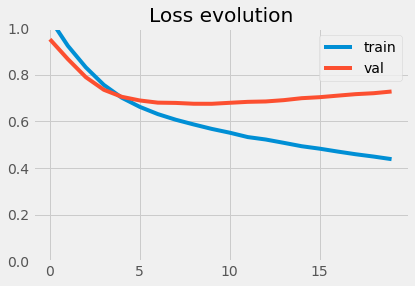

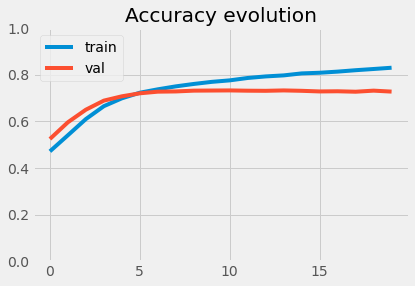

119/119 [==============================] - 0s 1ms/step
accuracy 0.4831
f1 macro 0.4794


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

## Comment: However the lemmatized data does poorly only around 48% for the scores

#### 4.1.5 A model with adam as optimizer + batch normalization

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               128128    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 3)                 195       
                                                                 
Total params: 137,347
Trainable params: 136,963
Non-tr

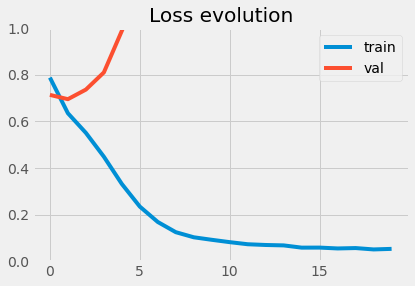

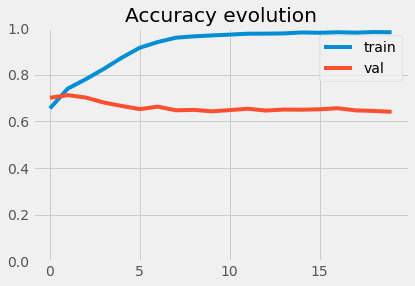

119/119 [==============================] - 0s 2ms/step
accuracy 0.6464
f1 macro 0.6468


In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
model.add(BatchNormalization())
model.add(Dense(64, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(3, activation='sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam' ,
    metrics=['accuracy'])

model.summary()

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs = 20, verbose=1, validation_split = 0.1)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

#Comment: not the best model but 62% scores (for f1 and accuracy) are not too bad

Epoch 1/20
579/579 [==============================] - 3s 5ms/step - loss: 0.9647 - accuracy: 0.6219 - val_loss: 0.7457 - val_accuracy: 0.6827
Epoch 2/20
579/579 [==============================] - 3s 4ms/step - loss: 0.6118 - accuracy: 0.7529 - val_loss: 0.7333 - val_accuracy: 0.6980
Epoch 3/20
579/579 [==============================] - 3s 4ms/step - loss: 0.5195 - accuracy: 0.7967 - val_loss: 0.7744 - val_accuracy: 0.6871
Epoch 4/20
579/579 [==============================] - 3s 4ms/step - loss: 0.4263 - accuracy: 0.8401 - val_loss: 0.8496 - val_accuracy: 0.6747
Epoch 5/20
579/579 [==============================] - 3s 4ms/step - loss: 0.3246 - accuracy: 0.8841 - val_loss: 0.9644 - val_accuracy: 0.6635
Epoch 6/20
579/579 [==============================] - 3s 5ms/step - loss: 0.2335 - accuracy: 0.9214 - val_loss: 1.1295 - val_accuracy: 0.6540
Epoch 7/20
579/579 [==============================] - 3s 5ms/step - loss: 0.1599 - accuracy: 0.9489 - val_loss: 1.2910 - val_accuracy: 0.6574
Epoch 

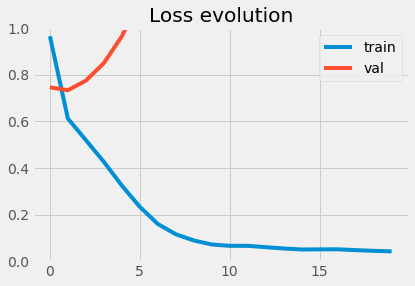

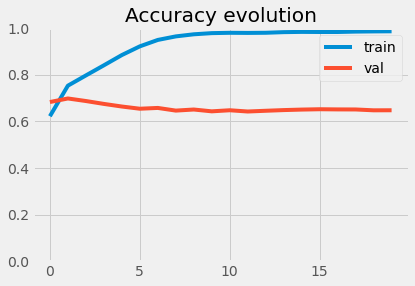

119/119 [==============================] - 0s 2ms/step
accuracy 0.4487
f1 macro 0.4447


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

## Comment: the lemmatized data does badly again

### 4.1 Part II: Deep learning neural network model with 1&2-gram data

In [ ]:
### Redefine x_train, y_train using 1 and 2-gram words
number_of_dimensions = 1500

x_train = train_cleaned_detokenized['OriginalTweet'].copy()
y_train = train_cleaned_detokenized['Sentiment'].copy()

x_train_lemmatized = train_cleaned_detokenized_lemmatized['OriginalTweet'].copy()
y_train_lemmatized = train_cleaned_detokenized_lemmatized['Sentiment'].copy()


x_test  = test_cleaned_detokenized['OriginalTweet'].copy()
y_test  = test_cleaned_detokenized['Sentiment'].copy()

x_test_lemmatized  = test_cleaned_detokenized_lemmatized['OriginalTweet'].copy()
y_test_lemmatized  = test_cleaned_detokenized_lemmatized['Sentiment'].copy()

## 1,2-gram words

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)

tfidf_vectorizer_lemmatized = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)

tfidf_vectorizer.fit(x_train)
tfidf_vectorizer_lemmatized.fit(x_train_lemmatized)

x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_train_lemmatized_features = tfidf_vectorizer_lemmatized.transform(x_train_lemmatized).toarray()

x_test_features  = tfidf_vectorizer.transform(x_test).toarray()
x_test_lemmatized_features = tfidf_vectorizer_lemmatized.transform(x_test_lemmatized).toarray()



In [ ]:
### Modify Sentiments to only 3 categories "Positive", "Neutral", "Negative" because we think this is more efficient,

y_train[y_train == 'Extremely Positive'] = 'Positive'
y_train[y_train == 'Extremely Negative'] = 'Negative'

y_test[y_test == 'Extremely Positive'] = 'Positive'
y_test[y_test == 'Extremely Negative'] = 'Negative'

y_train[0:20]

0      Neutral
1     Positive
2     Positive
3     Positive
4     Negative
5     Positive
6     Positive
7      Neutral
8     Positive
9     Negative
10     Neutral
11    Positive
12    Positive
13    Positive
14    Positive
15    Positive
16     Neutral
17     Neutral
18    Positive
19    Positive
Name: Sentiment, dtype: object

In [ ]:
encoder = LabelEncoder()

fit_train = encoder.fit(y_train)
fit_test = encoder.fit(y_test)

encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

# convert integers to dummy variables (i.e. one hot encoded)

dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)


#### 4.1.1 A model using SGD as the optimizer

In [ ]:
# Creating a neural network model

model = Sequential()
model.add(Dense(128 , activation= 'relu', input_shape=(number_of_dimensions, )))
model.add(Dense(64 , activation= 'relu'))
model.add(Dense(3, activation= 'sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               192128    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 200,579
Trainable params: 200,579
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0483 - accuracy: 0.4342 - val_loss: 1.0483 - val_accuracy: 0.4543
Epoch 2/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0389 - accuracy: 0.4368 - val_loss: 1.0447 - val_accuracy: 0.4546
Epoch 3/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0352 - accuracy: 0.4376 - val_loss: 1.0411 - val_accuracy: 0.4546
Epoch 4/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0306 - accuracy: 0.4446 - val_loss: 1.0354 - val_accuracy: 0.4606
Epoch 5/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0244 - accuracy: 0.4619 - val_loss: 1.0289 - val_accuracy: 0.4823
Epoch 6/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0161 - accuracy: 0.4877 - val_loss: 1.0199 - val_accuracy: 0.5046
Epoch 7/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0048 - accuracy: 0.5142 - val_loss: 1.0074 - val_accuracy: 0.5180
Epoch 

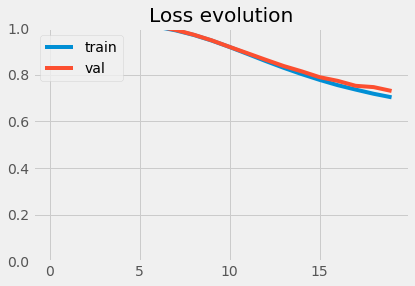

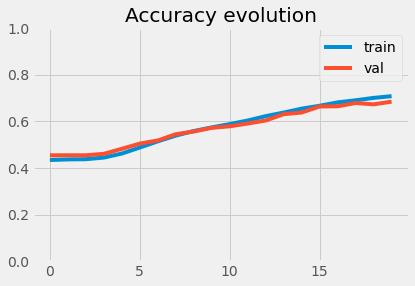

119/119 [==============================] - 0s 2ms/step
accuracy 0.6783
f1 macro 0.6691


In [ ]:
### Create a history to see the evolution of the accuracy on the test set

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs=20, verbose=1, validation_split=0.1)

### Plot the evolutions of loss and accuracy

plot_history(history)

### Check the performance on the test set

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

## Comment: accuracy 67.5% adn f1 macro 0.66% for this run, not too bad and it is better than 1-gram words

Epoch 1/20
579/579 [==============================] - 2s 4ms/step - loss: 1.0201 - accuracy: 0.5059 - val_loss: 0.9621 - val_accuracy: 0.5403
Epoch 2/20
579/579 [==============================] - 2s 4ms/step - loss: 0.9107 - accuracy: 0.5764 - val_loss: 0.8994 - val_accuracy: 0.5809
Epoch 3/20
579/579 [==============================] - 2s 4ms/step - loss: 0.8556 - accuracy: 0.6145 - val_loss: 0.8545 - val_accuracy: 0.6093
Epoch 4/20
579/579 [==============================] - 2s 4ms/step - loss: 0.8161 - accuracy: 0.6403 - val_loss: 0.8188 - val_accuracy: 0.6351
Epoch 5/20
579/579 [==============================] - 2s 4ms/step - loss: 0.7846 - accuracy: 0.6593 - val_loss: 0.7921 - val_accuracy: 0.6555
Epoch 6/20
579/579 [==============================] - 2s 4ms/step - loss: 0.7581 - accuracy: 0.6773 - val_loss: 0.7670 - val_accuracy: 0.6693
Epoch 7/20
579/579 [==============================] - 2s 4ms/step - loss: 0.7358 - accuracy: 0.6901 - val_loss: 0.7497 - val_accuracy: 0.6788
Epoch 

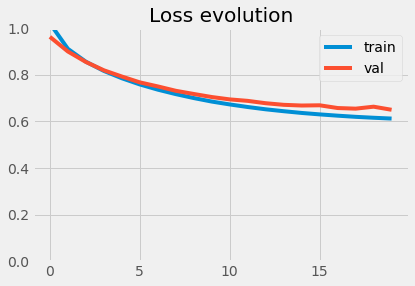

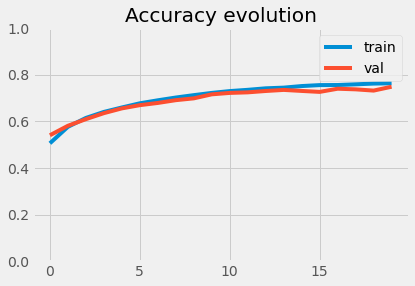

119/119 [==============================] - 0s 2ms/step
accuracy 0.5155
f1 macro 0.517


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

## Comment: 52% for both scores, pretty decent but better than 1-gram words

#### 4.1.2 A model using SGD with momentum

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 150)               225150    
                                                                 
 dense_19 (Dense)            (None, 80)                12080     
                                                                 
 dense_20 (Dense)            (None, 3)                 243       
                                                                 
Total params: 237,473
Trainable params: 237,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
515/515 [==============================] - 3s 6ms/step - loss: 1.0440 - accuracy: 0.4313 - val_loss: 1.0491 - val_accuracy: 0.4642
Epoch 2/20
515/515 [==============================] - 3s 5ms/step - loss: 1.0420 - accuracy: 0.4306 - val_loss: 1.0460 - val_accuracy: 0.4642
Epoch 3/20
515/515 [========

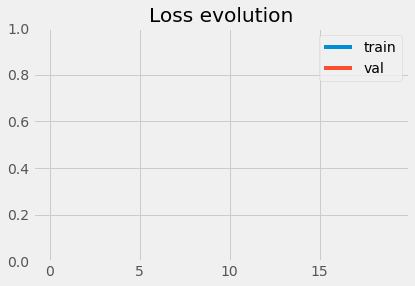

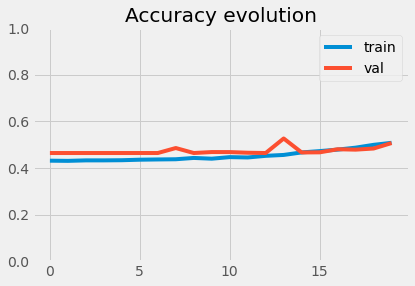

119/119 [==============================] - 0s 2ms/step
accuracy 0.5471
f1 macro 0.4826


In [ ]:
from tensorflow.keras import optimizers

model = Sequential()
model.add(Dense(150, activation='relu', input_shape=(number_of_dimensions,)))
model.add(Dense(80, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))

sgd = optimizers.SGD(momentum= 0.3)
model.compile(
    loss='categorical_crossentropy',
    optimizer= sgd ,
    metrics=['accuracy'])

model.summary()

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs=20, verbose=1, validation_split=0.2)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

### COmment : This model is bad, around 48% and 52% for both scores, not so good

Epoch 1/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0361 - accuracy: 0.4615 - val_loss: 1.0435 - val_accuracy: 0.4560
Epoch 2/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0331 - accuracy: 0.4681 - val_loss: 1.0425 - val_accuracy: 0.4694
Epoch 3/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0295 - accuracy: 0.4778 - val_loss: 1.0369 - val_accuracy: 0.4653
Epoch 4/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0255 - accuracy: 0.4915 - val_loss: 1.0331 - val_accuracy: 0.4684
Epoch 5/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0211 - accuracy: 0.4996 - val_loss: 1.0316 - val_accuracy: 0.4840
Epoch 6/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0157 - accuracy: 0.5112 - val_loss: 1.0255 - val_accuracy: 0.5231
Epoch 7/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0091 - accuracy: 0.5251 - val_loss: 1.0193 - val_accuracy: 0.5420
Epoch 

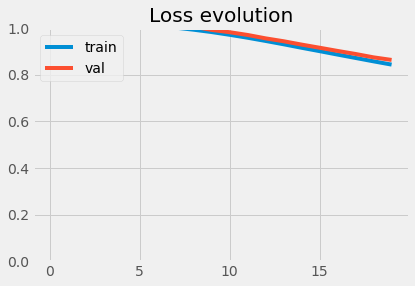

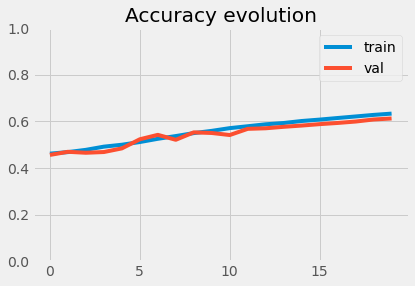

119/119 [==============================] - 0s 2ms/step
accuracy 0.5261
f1 macro 0.4794


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

#### 4.1.3 A model using RMSProp (Root Mean Square Propagation)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               192128    
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 3)                 195       
                                                                 
Total params: 200,579
Trainable params: 200,579
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
579/579 [==============================] - 4s 6ms/step - loss: 0.7475 - accuracy: 0.6745 - val_loss: 0.6662 - val_accuracy: 0.7313
Epoch 2/15
579/579 [==============================] - 3s 5ms/step - loss: 0.6175 - accuracy: 0.7558 - val_loss: 0.6334 - val_accuracy: 0.7468
Epoch 3/15
579/579 [========

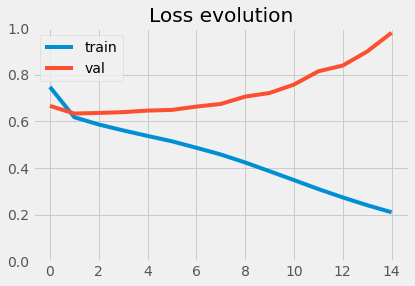

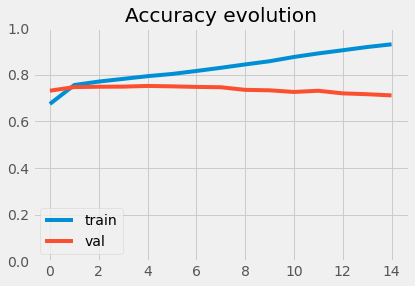

119/119 [==============================] - 0s 2ms/step
accuracy 0.6909
f1 macro 0.6908


In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer = 'rmsprop' ,
    metrics=['accuracy'])

model.summary()

### epochs should not be too large because of overfit.
history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs = 15, verbose=1, validation_split = 0.1)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

### COMMENT: Pretty good scores 70% and 71% on the test set, better then 1-gram data

Epoch 1/20
579/579 [==============================] - 3s 5ms/step - loss: 0.8462 - accuracy: 0.6312 - val_loss: 0.7132 - val_accuracy: 0.7077
Epoch 2/20
579/579 [==============================] - 3s 6ms/step - loss: 0.6241 - accuracy: 0.7547 - val_loss: 0.6757 - val_accuracy: 0.7286
Epoch 3/20
579/579 [==============================] - 3s 5ms/step - loss: 0.5646 - accuracy: 0.7841 - val_loss: 0.6824 - val_accuracy: 0.7391
Epoch 4/20
579/579 [==============================] - 3s 6ms/step - loss: 0.5208 - accuracy: 0.8024 - val_loss: 0.6813 - val_accuracy: 0.7345
Epoch 5/20
579/579 [==============================] - 3s 5ms/step - loss: 0.4799 - accuracy: 0.8201 - val_loss: 0.7030 - val_accuracy: 0.7396
Epoch 6/20
579/579 [==============================] - 3s 6ms/step - loss: 0.4393 - accuracy: 0.8375 - val_loss: 0.7330 - val_accuracy: 0.7298
Epoch 7/20
579/579 [==============================] - 3s 5ms/step - loss: 0.3999 - accuracy: 0.8529 - val_loss: 0.7595 - val_accuracy: 0.7289
Epoch 

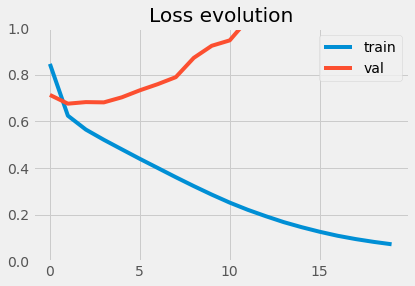

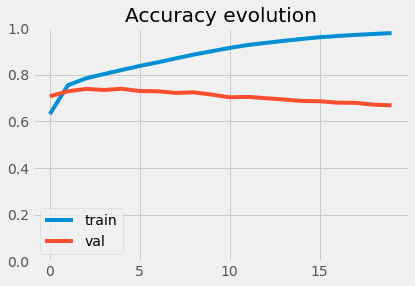

119/119 [==============================] - 0s 2ms/step
accuracy 0.426
f1 macro 0.4246


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

### Comment: the lemmatized data does bad as predicted

#### 4.1.4 A model with adam as optimizer + dropout 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               192128    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 3)                 195       
                                                                 
Total params: 200,579
Trainable params: 200,579
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
579/579 [============================

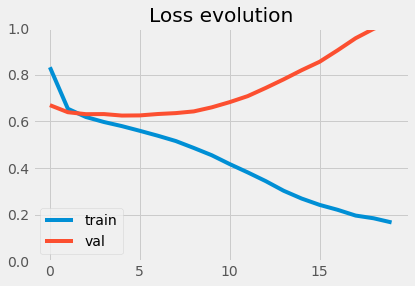

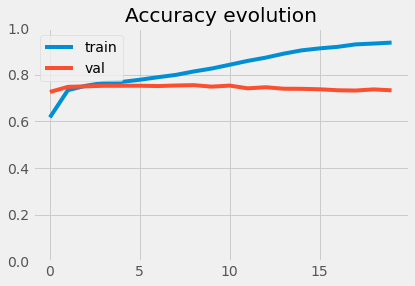

119/119 [==============================] - 0s 2ms/step
accuracy 0.703
f1 macro 0.7038


In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam' ,
    metrics=['accuracy'])

model.summary()

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs = 20, verbose=1, validation_split = 0.1)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

### Commetn: very good scores, as good as the same model with 1-gram words

Epoch 1/20
579/579 [==============================] - 3s 5ms/step - loss: 1.0310 - accuracy: 0.5595 - val_loss: 0.8230 - val_accuracy: 0.6251
Epoch 2/20
579/579 [==============================] - 3s 4ms/step - loss: 0.7422 - accuracy: 0.6810 - val_loss: 0.7244 - val_accuracy: 0.6878
Epoch 3/20
579/579 [==============================] - 3s 5ms/step - loss: 0.6312 - accuracy: 0.7378 - val_loss: 0.6912 - val_accuracy: 0.7157
Epoch 4/20
579/579 [==============================] - 3s 5ms/step - loss: 0.5582 - accuracy: 0.7771 - val_loss: 0.6897 - val_accuracy: 0.7201
Epoch 5/20
579/579 [==============================] - 3s 5ms/step - loss: 0.4928 - accuracy: 0.8073 - val_loss: 0.6996 - val_accuracy: 0.7269
Epoch 6/20
579/579 [==============================] - 3s 5ms/step - loss: 0.4378 - accuracy: 0.8299 - val_loss: 0.7173 - val_accuracy: 0.7264
Epoch 7/20
579/579 [==============================] - 3s 5ms/step - loss: 0.3847 - accuracy: 0.8528 - val_loss: 0.7520 - val_accuracy: 0.7247
Epoch 

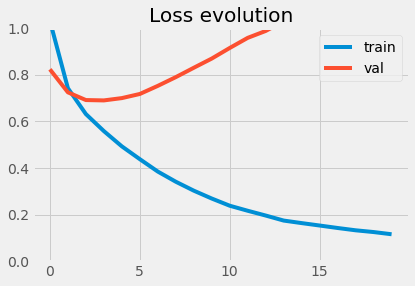

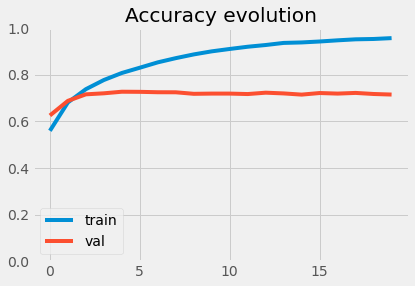

119/119 [==============================] - 0s 2ms/step
accuracy 0.5021
f1 macro 0.5027


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

### Comment: it can not get over 50%

#### 4.1.5 A model with adam as optimizer + batch normalization

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 128)               192128    
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_29 (Dense)            (None, 3)                 195       
                                                                 
Total params: 201,347
Trainable params: 200,963
Non-tr

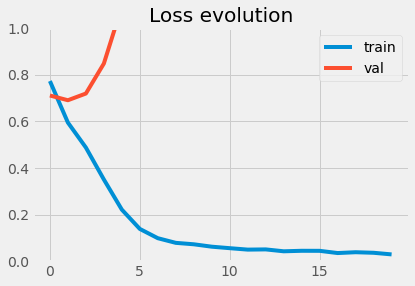

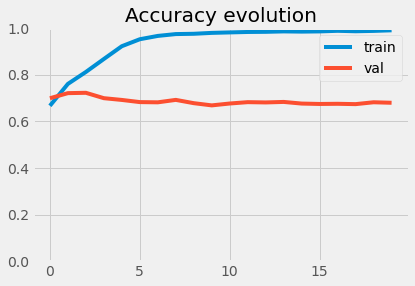

119/119 [==============================] - 0s 2ms/step
accuracy 0.6661
f1 macro 0.6675


In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
model.add(BatchNormalization())
model.add(Dense(64, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(3, activation='sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam' ,
    metrics=['accuracy'])

model.summary()

history = model.fit( x_train_features, dummy_y_train, batch_size = 64, epochs = 20, verbose=1, validation_split = 0.1)

plot_history(history)

model_evaluation(NN_model = model , x_test = x_test_features, y_test = encoded_y_test)

## Comment: The scores are pretty decent, around 65% for both, not too bad

Epoch 1/20
579/579 [==============================] - 3s 5ms/step - loss: 0.9172 - accuracy: 0.6434 - val_loss: 0.7055 - val_accuracy: 0.7046
Epoch 2/20
579/579 [==============================] - 3s 5ms/step - loss: 0.5535 - accuracy: 0.7829 - val_loss: 0.7125 - val_accuracy: 0.7087
Epoch 3/20
579/579 [==============================] - 3s 5ms/step - loss: 0.4314 - accuracy: 0.8399 - val_loss: 0.7740 - val_accuracy: 0.6983
Epoch 4/20
579/579 [==============================] - 3s 5ms/step - loss: 0.3063 - accuracy: 0.8929 - val_loss: 0.9092 - val_accuracy: 0.6808
Epoch 5/20
579/579 [==============================] - 3s 5ms/step - loss: 0.1921 - accuracy: 0.9369 - val_loss: 1.0878 - val_accuracy: 0.6810
Epoch 6/20
579/579 [==============================] - 3s 5ms/step - loss: 0.1167 - accuracy: 0.9640 - val_loss: 1.3535 - val_accuracy: 0.6569
Epoch 7/20
579/579 [==============================] - 3s 5ms/step - loss: 0.0766 - accuracy: 0.9772 - val_loss: 1.5323 - val_accuracy: 0.6579
Epoch 

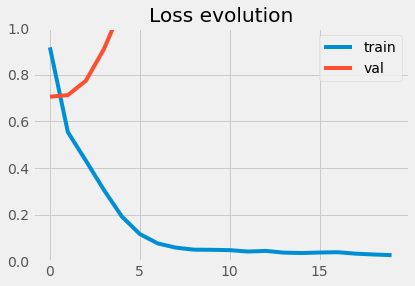

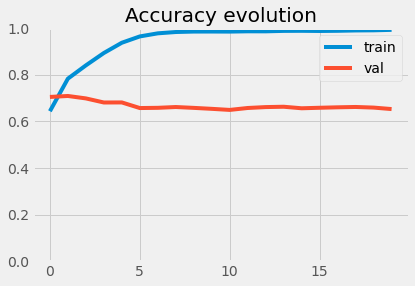

119/119 [==============================] - 0s 2ms/step
accuracy 0.4421
f1 macro 0.4432


In [ ]:
## Let's check with the lemmatized data 

history1 = model.fit(x_train_lemmatized_features, dummy_y_train, batch_size = 64, epochs=20, verbose = 1, validation_split=0.1)
plot_history(history1)
model_evaluation(NN_model = model , x_test = x_test_lemmatized_features, y_test = encoded_y_test)

## Comment: very bad, 45% for both scores

### 4.2 Logistic Regression 

In [57]:
### COmment: We have seen in the previous part, the lemmatized data + 1-gram words does not help, so we will use 
### the cleaned data without lemmatization and stemming + 1,2-gram tf-idf transformation

number_of_dimensions = 1000

x_train = train_cleaned_detokenized['OriginalTweet'].copy()
y_train = train_cleaned_detokenized['Sentiment'].copy()

x_test  = test_cleaned_detokenized['OriginalTweet'].copy()
y_test  = test_cleaned_detokenized['Sentiment'].copy()

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2), ### 1,2 gram words
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)

## Fit the model
tfidf_vectorizer.fit(x_train)

### Turn to arrays
x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_test_features  = tfidf_vectorizer.transform(x_test).toarray()



In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#### 4.2.1 Lasso optimization

In [64]:
# Grid of penalty parameters
param = [{"C": [0.5, 1, 5, 10, 12, 15, 30]}] # dictionary of the values of C used for GridSearchCV

#COMMENT: We use the following codes to get logistic regression + l1 penalty (LASSO case)

logitL = GridSearchCV(LogisticRegression(penalty="l1", solver="liblinear"), param ,cv =5, n_jobs = -1)
logitLasso = logitL.fit(x_train_features, encoded_y_train)
logitLasso.best_params_["C"]

0.5

In [65]:
# Computation of the loss

print("Best learning rate = %f, Best parameter  = %s" %
      (1.-logitLasso.best_score_ , logitLasso.best_params_))

Best learning rate = 0.274121, Best parameter  = {'C': 0.5}


In [66]:
# Prediction with the model

yChap = logitLasso.predict(x_test_features)

table = pd.crosstab(yChap, encoded_y_test)
print(table)

# Error on the test set
print("Test accuracy - Logistic regression  Lasso = %f" % (logitLasso.score(x_test_features, encoded_y_test)))

### Comment: very good prediction, 71% accuray. We rerun this several times and it is very consistent

col_0     0    1     2
row_0                 
0      1152  148   250
1       197  392   139
2       284   79  1157
Test accuracy - Logistic regression  Lasso = 0.711164


#### 4.2.2 Ridge optimization

In [67]:
# Grid of penalty parameters

param=[{"C":[0.5,1,5,10,12,15,30]}]


logitR = GridSearchCV(LogisticRegression(penalty="l2", solver="liblinear"), param ,cv = 5, n_jobs = -1)
logitRidge = logitR.fit(x_train_features, encoded_y_train)
logitRidge.best_params_["C"]

30

In [68]:
# Error computation  
print("Best score = %f, Best parameter = %s" %
      (1. - logitRidge.best_score_, logitRidge.best_params_))

Best score = 0.281434, Best parameter = {'C': 30}


In [69]:
# Prediction 
yChap = logitRidge.predict(x_test_features)

#Todo confusion matrix 
table1 = pd.crosstab(yChap, encoded_y_test)
print(table1)

# Error on the test set
print("Accuracy on the test set = %f" % (logitRidge.score(x_test_features, encoded_y_test)))

### Comment: slightly better than Lasso, in all runs

col_0     0    1     2
row_0                 
0      1155  146   243
1       184  381   129
2       294   92  1174
Accuracy on the test set = 0.713533


### 4.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# RF with 3 features and 100 trees
rf3 = RandomForestClassifier(n_estimators=100, max_features=3)
rfOpt = rf3.fit(x_train_features, encoded_y_train)

In [ ]:
# Prediction on the test set

yChapRF = rfOpt.predict(x_test_features)

# Confusion matrix

tableRF = pd.crosstab(yChapRF, encoded_y_test)
print(tableRF)

# Prediction error on the test set
print("Accuracy with  random forest opt -quantitative = %f" % (rfOpt.score(x_test_features, encoded_y_test)))

### Comment: 65% accuracy when we run this, pretty decent, but not too bad

col_0     0    1     2
row_0                 
0      1089  187   278
1       102  251    74
2       442  181  1194
Accuracy with  random forest opt -quantitative = 0.667193


### 4.4 Support Vector Machine 


In [ ]:
##COMMENT: In this section, we would like to perform LinearSVC on the dataset to see if it is better than above case

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

## COMMENT: We could not perform parameters tuning for this case since the data set has over 1000 observations so the complexity is 
## O(n_features ** n^2_observations), so we tried many different values of C instead, such as 0.1, 0.5, 1, 1.5, 2, 4, 6 instead, the error rates are around
## 15-18%, not so bad. 

svmlinear = make_pipeline(StandardScaler(), LinearSVC(C=0.1))

svmlinear.fit(x_train_features, encoded_y_train)

# Prediction on the test set

yChapSVM = svmlinear.predict(x_test_features)

# Confusion matrix

tableSVM = pd.crosstab(yChapSVM, encoded_y_test)
print(tableSVM) 

# Prediction error on the test set
print("Test accuracy of SVC model = %f" % (svmlinear.score(x_test_features, encoded_y_test)))

## COMMENT: When we ran this code the accuracy rate is 72.5%, not bad at all

col_0     0    1     2
row_0                 
0      1142  153   263
1       193  379   130
2       298   87  1153
Test accuracy of SVC model = 0.704055


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### 4.5 Gradient Boosting 

In [ ]:
## Simple model with no parameters tuning

import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth = 3, n_estimators= 230, eta = 0.3, objective='multi:softprob', num_class = 3,  random_state=41)
xgb_model.fit(x_train_features, encoded_y_train)

yXG = xgb_model.predict(x_test_features)

tableXG = pd.crosstab(yXG,encoded_y_test)
print(tableXG)

print("Test accuracy Gradient Boosting = %f" % (xgb_model.score(x_test_features,encoded_y_test)))

## COMMENT: Accuracy rate is 66%, not so bad for multi classification

col_0    0    1     2
row_0                
0      995   91   218
1      147  279   101
2      491  249  1227
Test accuracy Gradient Boosting = 0.658504


### 4.6 Naive Bayes

#### 4.6.1 Gaussian Naive Bayes

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(x_train_features, encoded_y_train).predict(x_test_features)

print("Number of mislabeled points out of a total %d points : %d" % (x_test_features.shape[0], (encoded_y_test != y_pred).sum()))

tableGNB = pd.crosstab(y_pred,encoded_y_test)
print(tableGNB)

print("Test accuracy Gaussian Naive Bayes = %f" % (1-((encoded_y_test != y_pred).sum()/x_test_features.shape[0])))

## COMMENT: The computation is very fast due to its simplicity. However, this
## reflects poorly on the accuracy.

Number of mislabeled points out of a total 3798 points : 1529
col_0    0    1    2
row_0               
0      905   82  296
1      462  477  363
2      266   60  887
Test accuracy Gaussian Naive Bayes = 0.597420


In [ ]:
# probabilities calculated for each sentiment. positive - neutral - negative
gnb.class_prior_

array([0.37412834, 0.18740433, 0.43846733])

#### 4.6.2 Categorical Naive Bayes

In [ ]:
from sklearn.naive_bayes import CategoricalNB

cnb = CategoricalNB()
y_pred = cnb.fit(x_train_features, encoded_y_train).predict(x_train_features)

print("Number of mislabeled points out of a total %d points : %d" % (x_train_features.shape[0], (encoded_y_train != y_pred).sum()))

tableCNB = pd.crosstab(y_pred,encoded_y_train)
print(tableCNB)

print("Test accuracy Categorical Naive Bayes = %f" % (1-((encoded_y_train != y_pred).sum()/x_train_features.shape[0])))

## COMMENT: very bad prediction only 45% when we run this.

Number of mislabeled points out of a total 41157 points : 22976
col_0      0     1      2
row_0                    
0         31    11      3
1          5   113      6
2      15362  7589  18037
Test accuracy Categorical Naive Bayes = 0.441747


## 5. Generating text sequence using RNN with LSTM model

In [ ]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

# set seeds for reproducability
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore") ## ignore many warnings that we do not care about (because of not enough Ram + runtime)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
### Here we only use a random 1000 tweets for our corpus because the training time will be too much and my computer 
### RAM will be completely used and leads to a crashed session

newcorpus = np.random.choice(df_halfway['OriginalTweet'],1000)  
newcorpus[:10]

array(['terrific piece executives from loblaws sobeys walmart canada go from head office to bagging groceries stocking shelves they pull two shifts and then say theyre proud to contribute as they drive home in their tesla covid19',
       'yesterday my friend was at the emptyshelved grocery store where she met a young man who was in tears because he couldnt find formula for his baby the necessity hoarders had bought it allpeople stop hoarding enough is enoughcoronaviruspandemic coronacrisis',
       'european supermarket giants run out of stock as covid2019 threatens business closures in zimbabwe shelves are forever empty calmness will prevail',
       'scotpol1314 angebay youre either a gers denier or somehow cant fathom how much trouble wed be in currently with covid19 and current oil prices given gers figures anyone suggesting wed be doing ok currently is clearly unworthy of having further',
       'realist2016jlp the media inspired covid 19 pandemic panic is turning the us into ven

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

### We define a useful function to get the tokens from a corpus
def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

### Take out input sequences and number of words.

inp_sequences, total_words = get_sequence_of_tokens(newcorpus)
inp_sequences[:10]

[[2255, 1063],
 [2255, 1063, 2256],
 [2255, 1063, 2256, 26],
 [2255, 1063, 2256, 26, 2257],
 [2255, 1063, 2256, 26, 2257, 2258],
 [2255, 1063, 2256, 26, 2257, 2258, 556],
 [2255, 1063, 2256, 26, 2257, 2258, 556, 557],
 [2255, 1063, 2256, 26, 2257, 2258, 556, 557, 63],
 [2255, 1063, 2256, 26, 2257, 2258, 556, 557, 63, 26],
 [2255, 1063, 2256, 26, 2257, 2258, 556, 557, 63, 26, 1409]]

In [ ]:
## Create a function that generates padded sequences 

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = np_utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)


In [ ]:
## Create a function that create a sequential model with LSTM 100, we use dropout to enhance the performance
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam') 
    ## we use adam + dropout technique here because it is the best tool according the the neural network part above
    return model

## Create our RNN with LSTM model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 56, 10)            61030     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_30 (Dense)            (None, 6103)              616403    
                                                                 
Total params: 721,833
Trainable params: 721,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### This takes long (last runtime: 1h 15m ) when epoch = 100. the training would be better

model.fit(predictors, label, epochs=100, verbose=5) 


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 79

In [ ]:
### We define a function that generates texts from a given sequence of texts.

def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]  ## create a list with tokenized words
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predict_x  = model.predict(token_list, verbose=0)  ## predict the probabilities of the indexes of the word
        predicted = np.argmax(predict_x,axis=1) ## take out the word with largest probability
        output_word = ""
        for word,index in tokenizer.word_index.items(): ## print out the next words
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [ ]:
## Let's take a look at how the texts are generated

print(generate_text("toilet paper", 4, model, max_sequence_len))
print(generate_text("Trump", 15, model, max_sequence_len))
print(generate_text("Antivax people are dumb", 10, model, max_sequence_len))
print(generate_text("Stock prices will", 15, model, max_sequence_len))
print(generate_text("Wear your face mask and", 15, model, max_sequence_len))
print(generate_text("the price we pay is", 10, model, max_sequence_len))

## Comment: Most sentences generated here may have no meaning due to the size of the corpus, if we have enough RAM and
## time we may take the whole tweets as our corpus and train the above models with more epochs, the results may be better 

Toilet Paper The Friends The Negative
Trump Wasted The Golden Time To Slow Down The Spread Of Covid 19 Wear Masks When
Antivax People Are Dumb Taking 1 To Get To The Supermarket In The Supermarket
Stock Prices Will Having The Money Are Not Many To Shelter Or We Have Also Do To The
Wear Your Face Mask And Shelter As The Spread Of The Virus So Leeds Covid19 Is There Is Also Sold
The Price We Pay Is How Its Supermarket Amid The Covid19 Pandemic Is Not In
